In [1]:
import deimos
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import sys
import PeakDetective
import PeakDetective.detection_helper as detection_helper
import scipy.stats as stats
import seaborn as sb
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix
import sklearn.metrics as met
import random as rd
import importlib
import pickle as pkl

def makePRCPlot(pred,true,noSkill=True):

    prec, recall, threshs = met.precision_recall_curve(true, pred)

    auc = np.round(met.auc(recall, prec), 4)

    plt.plot(recall, prec, label="prAUC=" + str(auc))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    if noSkill:
        numPositive = len([x for x in true if x > 0.5])
        numNegative = len(true) - numPositive
        plt.plot([0, 1.0],
                 [numPositive / float(numPositive + numNegative), numPositive / float(numPositive + numNegative)],
                 label="NSL prAUC=" + str(
                     np.round(numPositive / float(numPositive + numNegative), 4)))
    plt.legend()
    return auc

def makeViolinPlot(pred,true):
    
    plt_dict = {}
    
    for p,t in zip(pred,true):
        if t > 0.5:
            group = "true peak"
        else:
            group = "artifact"
        plt_dict[len(plt_dict)] = {"group":group,"prediction":p}
        
    plt_dict = pd.DataFrame.from_dict(plt_dict,orient="index")
    
    sb.violinplot(data=plt_dict,x="group",y="prediction",cut=0)


In [2]:
#importlib.reload(PeakDetective)

In [3]:
datadir = "../data/ST001882_GT_RP_Positive/"
resolution = 60
window = 1.0

In [4]:
ms1ppm = 11.5
peakWidth = (8.576,30)
s2n = 9.1
noise = 12970
prefilter = 1
det = detection_helper.PeakList()
#det.runXCMS(datadir, "xcms_peak_list.csv", "negative", ms1ppm, peakWidth,s2n=s2n,noise=noise,prefilter=prefilter)
det.readXCMSPeakList(datadir+"xcms_peak_list.csv")
det.to_skyline(datadir+"xcms_peak_list_transition_list.csv","Negative",moleculeListName = "XCMS peaks")
peakList = pd.DataFrame(det.peakList)
peakList["rt"] = .5 * peakList["rt_start"] + .5 * peakList["rt_end"]
peakList = peakList[["mz","rt"]]
peakList

mz        rt
1       150.106131  0.804357
2       150.062904  1.259868
3       150.026482  1.748128
4       150.026490  2.848530
5       150.026651  1.081114
...            ...       ...
32734  1974.536430  8.819054
32735  1979.207415  6.250337
32736  1980.210251  6.246437
32737  1981.211674  6.248230
32738  1982.212953  6.250339

[32738 rows x 2 columns]

In [5]:
files = [x for x in os.listdir(datadir) if ".mzML" in x]
print(files)
raw_data = []
for file in files:
    temp = PeakDetective.rawData()
    temp.readRawDataFile(datadir + file,ms1ppm)
    raw_data.append(temp)
    

['QC_01.mzML', 'QC_02.mzML', 'QC_03.mzML', 'QC_04.mzML', 'QC_05.mzML', 'QC_06.mzML', 'QC_07.mzML']


In [6]:
integ = PeakDetective.PeakDetective(numCores = 15,resolution=resolution)

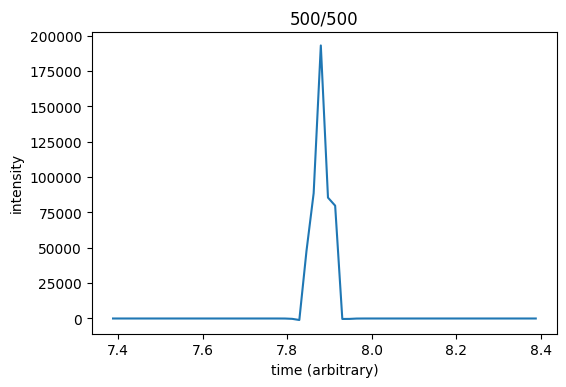

Enter classification (1=True Peak, 0=Artifact): 


 1


In [7]:
if __name__ == "__main__":
    inds = list(peakList.index.values)
    inds = rd.sample(inds,500)
    tmp = peakList.loc[inds,:]
    print(tmp)
    peakList_labeled = integ.label_peaks(raw_data[0],tmp)
    peakList_labeled.to_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"))

In [8]:
peakList_labeled = pd.read_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"),index_col=0)

In [9]:
if __name__ == "__main__":
    rts = peakList["rt"].values
    X = integ.makeDataMatrix(raw_data,peakList["mz"],rts)

forming matrix |██████████████████████████████████████████████████| 100.0% 


In [10]:
if __name__ == "__main__":
    rts = peakList_labeled["rt"].values
    X_labeled = integ.makeDataMatrix(raw_data[:1],peakList_labeled["mz"],rts)
    y_labeled = peakList_labeled["classification"].values
    y_labeled = np.array([[-1*y + 1,y] for y in y_labeled])

forming matrix |██████████████████████████████████████████████████| 100.0% 


In [11]:
X_signal = integ.generateSignalPeaks(peakList,raw_data,n=50)
X_noise = integ.generateFalsePeaks(peakList,raw_data,n=50)
X_syn = np.concatenate((X_signal,X_noise),axis=0)
y_syn = np.array([[0.0,1.0] for _ in X_signal] + [[1.0,0.0] for _ in X_noise])

forming matrix |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 


In [12]:
pkl.dump([X,X_labeled,y_labeled,X_syn,y_syn],open(datadir + "matrices.pkl","wb"))
#pkl.dump([X,X_labeled,y_labeled],open(datadir + "matrices.pkl","wb"))

In [7]:
[X,X_labeled,y_labeled,X_syn,y_syn] = pkl.load(open(datadir + "matrices.pkl","rb"))
#[X,X_labeled,y_labeled] = pkl.load(open(datadir + "matrices.pkl","rb"))

In [13]:
if __name__ == "__main__":
    integ.trainSmoother(peakList,raw_data,100000,20,64,0.1)

generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
done
fitting smoother...
Epoch 1/20
1407/1407 [==============================] - 29s 20ms/step - loss: 0.1384 - mean_absolute_error: 0.0615 - val_loss: 0.0817 - val_mean_absolute_error: 0.0146
Epoch 2/20
1407/1407 [==============================] - 25s 18ms/step - loss: 0.0779 - mean_absolute_error: 0.0128 - val_loss: 0.0747 - val_mean_absolute_error: 0.0113
Epoch 3/20
1407/1407 [==============================] - 27s 19ms/step - loss: 0.0739 - mean_absolute_error: 0.0102 - val_loss: 0.0730 - val_mean_absolute_error: 0.0099
Epoch 4/20
1407/1407 [==============================] - 28s 20ms/step - loss: 0.0727 - mean_absolute_error: 0.0092 - val_loss: 0.0720 - val_mean_absolute_error: 0.0091
Epoch 5/20
1407/1407 [==============================] - 28s 20ms/step - loss: 0.0720 - mean_absolute_error: 0.0087 - val_loss: 0.0714 - val_mean_absolute_error: 0.0088
Epoch 6/20
1407/1407 [==================

In [14]:
valInds = list(range(len(X_labeled)))
valInds = rd.sample(valInds,k=50)

X_val = X_labeled[valInds]
y_val = y_labeled[valInds]

X_labeled = X_labeled[[x for x in range(len(X_labeled)) if x not in valInds]]
y_labeled = y_labeled[[x for x in range(len(y_labeled)) if x not in valInds]]

In [15]:
X_labeled_norm = PeakDetective.normalizeMatrix(X_labeled)
X_labeled_smoothed = integ.smoother.predict(PeakDetective.normalizeMatrix(X_labeled))

15/15 [==============================] - 0s 6ms/step


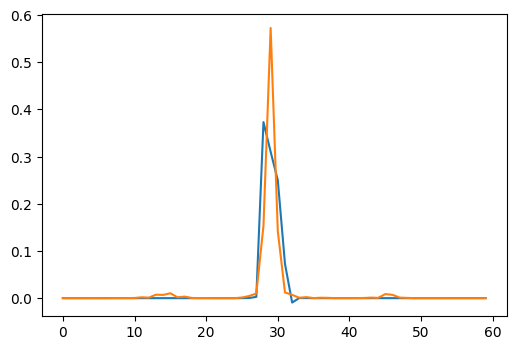

In [18]:
ind = rd.choice(list(range(len(X_labeled))))
plt.plot(X_labeled_norm[ind])
plt.plot(X_labeled_smoothed[ind])

In [19]:
if __name__ == "__main__":
    integ.trainClassifier(X_labeled,y_labeled,X_val,y_val,1000,32,5)

2/2 [==============================] - 0s 4ms/step
loss: 0.616223156452179 mean_absolute_error: 0.3844330906867981 val loss: 0.6291590332984924 val_mean_absolute_error: 0.3923950493335724 numEpochs: 144


In [20]:
y_val_scores_supervised = integ.classifyMatrix(X_val)

2/2 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 37ms/step
loss: 0.4686594605445862 mean_absolute_error: 0.23617053031921387 val loss: 0.511020839214325 val_mean_absolute_error: 0.2568807899951935 numEpochs: 135
7160/7160 [==============================] - 9s 1ms/step


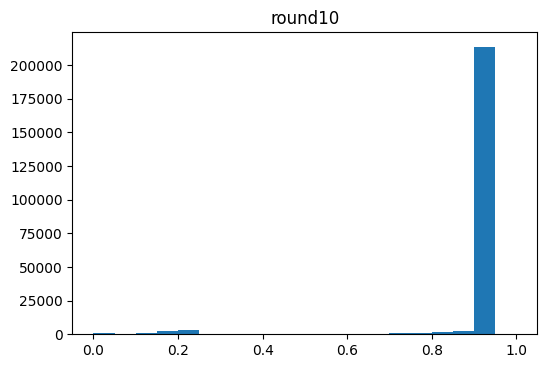

229106 unclassified features remaining
Continue with another iteration? (1=Yes, 0=No): 


 0


In [21]:
if __name__ == "__main__":
    integ.trainClassifierActive(X,X_syn,y_syn,1000,32,5,numVal = 10,numManualPerRound=5,inJupyter=True)

In [22]:
y_val_scores_active = integ.classifyMatrix(X_val)

2/2 [==============================] - 0s 4ms/step


0.8298

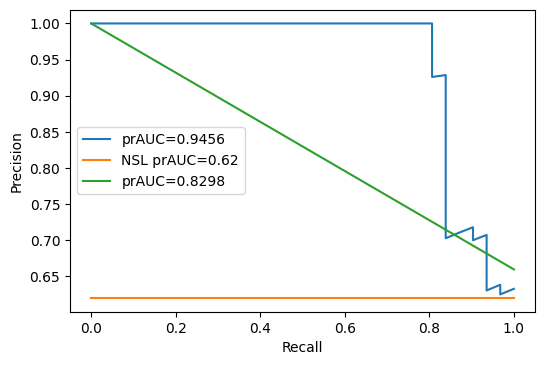

In [23]:
makePRCPlot(y_val_scores_supervised[:,1],y_val[:,1],noSkill=True)
makePRCPlot(y_val_scores_active[:,1],y_val[:,1],noSkill=False)

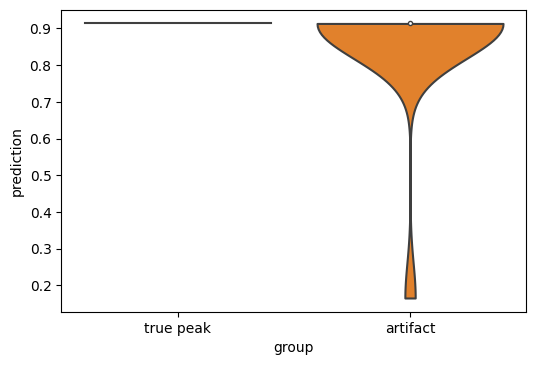

In [24]:
makeViolinPlot(y_val_scores_active[:,1],y_val[:,1])

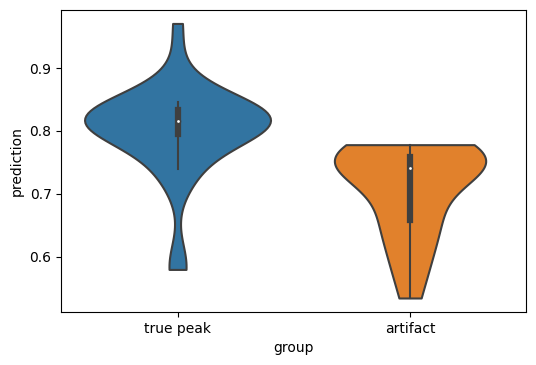

In [25]:
makeViolinPlot(y_val_scores_supervised[:,1],y_val[:,1])

In [26]:
pkl.dump(integ,open(datadir + "PeakDetective.pkl","wb"))

INFO:tensorflow:Assets written to: ram://7cc70ae3-d522-472f-ba80-223f7586eef5/assets


INFO:tensorflow:Assets written to: ram://7cc70ae3-d522-472f-ba80-223f7586eef5/assets


INFO:tensorflow:Assets written to: ram://92fab3b7-6af0-41f6-83d1-fb86845f7b2d/assets


INFO:tensorflow:Assets written to: ram://92fab3b7-6af0-41f6-83d1-fb86845f7b2d/assets


INFO:tensorflow:Assets written to: ram://84fd5ef7-330a-417b-9354-7af7c9acccb5/assets


INFO:tensorflow:Assets written to: ram://84fd5ef7-330a-417b-9354-7af7c9acccb5/assets


In [27]:
if __name__ == "__main__":
    peak_curated,peak_scores,peak_intensities = integ.curatePeaks(raw_data,peakList,threshold=0.5)
    peak_curated

generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
7162/7162 [==============================] - 9s 1ms/step


In [28]:
y = integ.classifyMatrix(X)

7162/7162 [==============================] - 9s 1ms/step


In [29]:
peak_curated

mz        rt  ../data/ST001882_GT_RP_Positive/QC_01.mzML  \
1       150.106131  0.804357                                         1.0   
2       150.062904  1.259868                                         1.0   
3       150.026482  1.748128                                         1.0   
4       150.026490  2.848530                                         1.0   
5       150.026651  1.081114                                         1.0   
...            ...       ...                                         ...   
32734  1974.536430  8.819054                                         1.0   
32735  1979.207415  6.250337                                         1.0   
32736  1980.210251  6.246437                                         1.0   
32737  1981.211674  6.248230                                         1.0   
32738  1982.212953  6.250339                                         1.0   

       ../data/ST001882_GT_RP_Positive/QC_02.mzML  \
1                                             1.0   
2                                             1.0   
3                                             1.0   
4                                             1.0   
5                                             1.0   
...                                           ...   
32734                                         0.0   
32735                                         1.0   
32736                                         1.0   
32737                                         1.0   
32738                                         1.0   

       ../data/ST001882_GT_RP_Positive/QC_03.mzML  \
1                                             1.0   
2                                             1.0   
3                                             1.0   
4                                             1.0   
5                                             1.0   
...                                           ...   
32734                                         1.0   
32735                                         1.0   
32736                                         1.0   
32737                                         1.0   
32738                                         1.0   

       ../data/ST001882_GT_RP_Positive/QC_04.mzML  \
1                                             1.0   
2                                             1.0   
3                                             1.0   
4                                             1.0   
5                                             1.0   
...                                           ...   
32734                                         0.0   
32735                                         1.0   
32736                                         1.0   
32737                                         1.0   
32738                                         1.0   

       ../data/ST001882_GT_RP_Positive/QC_05.mzML  \
1                                             1.0   
2                                             1.0   
3                                             1.0   
4                                             1.0   
5                                             1.0   
...                                           ...   
32734                                         0.0   
32735                                         1.0   
32736                                         1.0   
32737                                         1.0   
32738                                         1.0   

       ../data/ST001882_GT_RP_Positive/QC_06.mzML  \
1                                             1.0   
2                                             1.0   
3                                             1.0   
4                                             1.0   
5                                             1.0   
...                                           ...   
32734                                         1.0   
32735                                         1.0   
32736                                         1.0   
32737                    

In [30]:
peak_scores

mz        rt  ../data/ST001882_GT_RP_Positive/QC_01.mzML  \
1       150.106131  0.804357                                    0.913748   
2       150.062904  1.259868                                    0.913748   
3       150.026482  1.748128                                    0.913748   
4       150.026490  2.848530                                    0.913748   
5       150.026651  1.081114                                    0.913748   
...            ...       ...                                         ...   
32734  1974.536430  8.819054                                    0.913748   
32735  1979.207415  6.250337                                    0.913748   
32736  1980.210251  6.246437                                    0.913748   
32737  1981.211674  6.248230                                    0.913748   
32738  1982.212953  6.250339                                    0.913748   

       ../data/ST001882_GT_RP_Positive/QC_02.mzML  \
1                                        0.913748   
2                                        0.913748   
3                                        0.913748   
4                                        0.913748   
5                                        0.913748   
...                                           ...   
32734                                    0.073234   
32735                                    0.913748   
32736                                    0.913748   
32737                                    0.913748   
32738                                    0.913748   

       ../data/ST001882_GT_RP_Positive/QC_03.mzML  \
1                                        0.913748   
2                                        0.913748   
3                                        0.913748   
4                                        0.913748   
5                                        0.913748   
...                                           ...   
32734                                    0.913748   
32735                                    0.913748   
32736                                    0.913748   
32737                                    0.913748   
32738                                    0.913748   

       ../data/ST001882_GT_RP_Positive/QC_04.mzML  \
1                                        0.913748   
2                                        0.913748   
3                                        0.913748   
4                                        0.913748   
5                                        0.913748   
...                                           ...   
32734                                    0.173400   
32735                                    0.913748   
32736                                    0.913748   
32737                                    0.913748   
32738                                    0.913748   

       ../data/ST001882_GT_RP_Positive/QC_05.mzML  \
1                                        0.913748   
2                                        0.913748   
3                                        0.913748   
4                                        0.913748   
5                                        0.913748   
...                                           ...   
32734                                    0.132782   
32735                                    0.913748   
32736                                    0.913748   
32737                                    0.913748   
32738                                    0.913748   

       ../data/ST001882_GT_RP_Positive/QC_06.mzML  \
1                                        0.913748   
2                                        0.913748   
3                                        0.913748   
4                                        0.913748   
5                                        0.913748   
...                                           ...   
32734                                    0.913748   
32735                                    0.913748   
32736                                    0.913748   
32737                    

In [31]:
peak_intensities

mz        rt  ../data/ST001882_GT_RP_Positive/QC_01.mzML  \
1       150.106131  0.804357                                2.606667e+05   
2       150.062904  1.259868                                2.105648e+05   
3       150.026482  1.748128                                2.490275e+07   
4       150.026490  2.848530                                4.791707e+06   
5       150.026651  1.081114                                2.665136e+05   
...            ...       ...                                         ...   
32734  1974.536430  8.819054                                0.000000e+00   
32735  1979.207415  6.250337                                5.739178e+04   
32736  1980.210251  6.246437                                1.854903e+05   
32737  1981.211674  6.248230                                1.811025e+05   
32738  1982.212953  6.250339                                9.724207e+04   

       ../data/ST001882_GT_RP_Positive/QC_02.mzML  \
1                                    2.541543e+05   
2                                    3.249217e+05   
3                                    2.332369e+07   
4                                    4.975194e+06   
5                                    3.213907e+05   
...                                           ...   
32734                                4.056255e+04   
32735                                1.552634e+05   
32736                                2.369348e+05   
32737                                1.869354e+05   
32738                                8.389420e+04   

       ../data/ST001882_GT_RP_Positive/QC_03.mzML  \
1                                    3.071151e+05   
2                                    2.677686e+05   
3                                    2.539838e+07   
4                                    4.301602e+06   
5                                    3.199068e+05   
...                                           ...   
32734                                1.203393e+05   
32735                                1.313523e+05   
32736                                2.608711e+05   
32737                                1.713365e+05   
32738                                1.196528e+05   

       ../data/ST001882_GT_RP_Positive/QC_04.mzML  \
1                                    3.817362e+05   
2                                    2.783955e+05   
3                                    2.609836e+07   
4                                    3.900765e+06   
5                                    3.305049e+05   
...                                           ...   
32734                                6.432057e+03   
32735                                0.000000e+00   
32736                                2.039654e+05   
32737                                1.411156e+05   
32738                                1.083120e+05   

       ../data/ST001882_GT_RP_Positive/QC_05.mzML  \
1                                    2.131647e+05   
2                                    2.987272e+05   
3                                    2.763394e+07   
4                                    5.063156e+06   
5                                    3.400490e+05   
...                                           ...   
32734                                1.048081e+05   
32735                                1.529833e+05   
32736                                2.485972e+05   
32737                                2.562187e+05   
32738                                4.955208e+04   

       ../data/ST001882_GT_RP_Positive/QC_06.mzML  \
1                                    2.496059e+05   
2                                    2.792919e+05   
3                                    2.666006e+07   
4                                    3.556789e+06   
5                                    3.063825e+05   
...                                           ...   
32734                                1.092976e+05   
32735                                1.118034e+05   
32736                                1.745250e+05   
32737                    

In [32]:
peakList

mz        rt
1       150.106131  0.804357
2       150.062904  1.259868
3       150.026482  1.748128
4       150.026490  2.848530
5       150.026651  1.081114
...            ...       ...
32734  1974.536430  8.819054
32735  1979.207415  6.250337
32736  1980.210251  6.246437
32737  1981.211674  6.248230
32738  1982.212953  6.250339

[32738 rows x 2 columns]

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


MemoryError: Unable to allocate 196. GiB for an array with shape (26258413195,) and data type float64

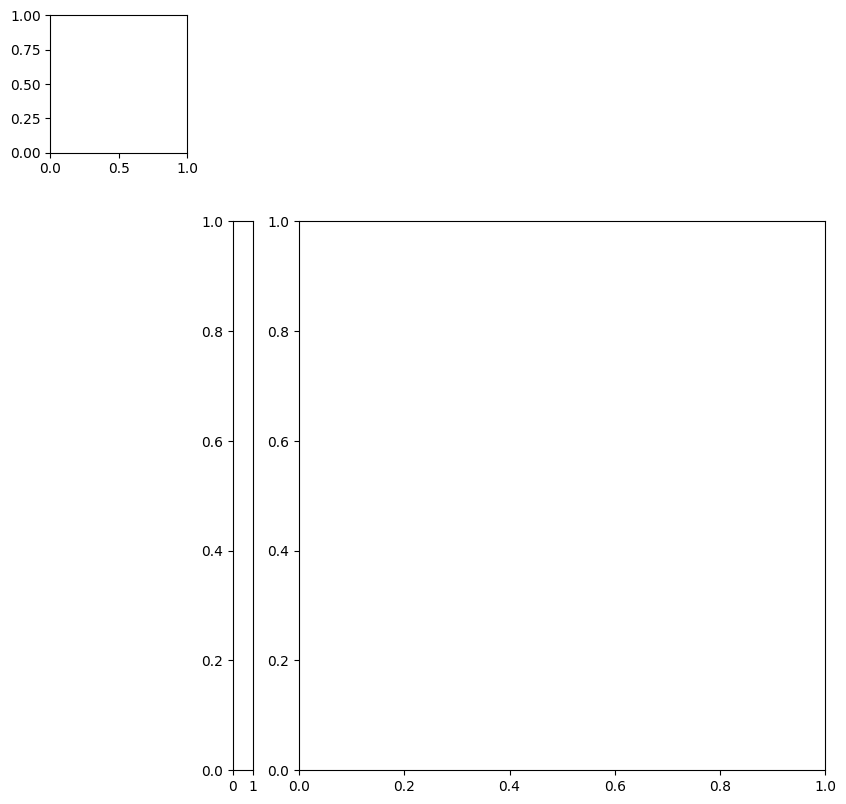

In [33]:
def tmp(val):
    if val > 0.5:
        return "blue"
    return "grey"
row_colors = [tmp(x) for x in y[:,1]]
sb.clustermap(PeakDetective.normalizeMatrix(X),col_cluster=False,yticklabels=False,cmap="magma",vmin=0.0,vmax=1.0,row_colors=row_colors)

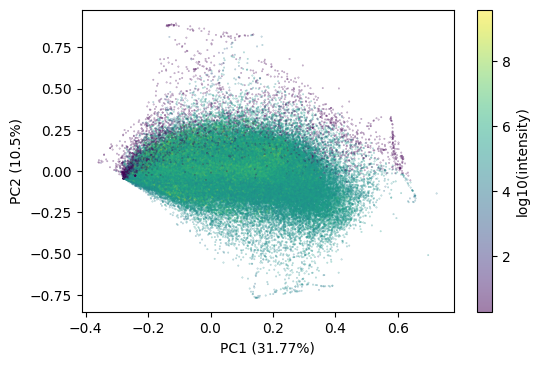

In [34]:
pca = PCA(2)
loads = pca.fit_transform(PeakDetective.normalizeMatrix(X))
plt.scatter(loads[:,0],loads[:,1],c=np.log10(np.array([np.max([2, PeakDetective.integratePeak(x)]) for x in X])),s=.1,alpha=.5)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar(label="log10(intensity)")

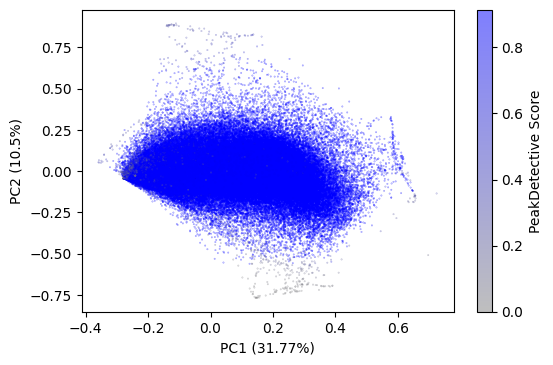

In [35]:
pca = PCA(2)
loads = pca.fit_transform(PeakDetective.normalizeMatrix(X))
colormap = LinearSegmentedColormap.from_list("test",colors=["grey", "blue"],N=256)
plt.scatter(loads[:,0],loads[:,1],c=y[:,1],s=.1,alpha=.5,cmap=colormap)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar(label="PeakDetective Score")

Text(0, 0.5, '% of features')

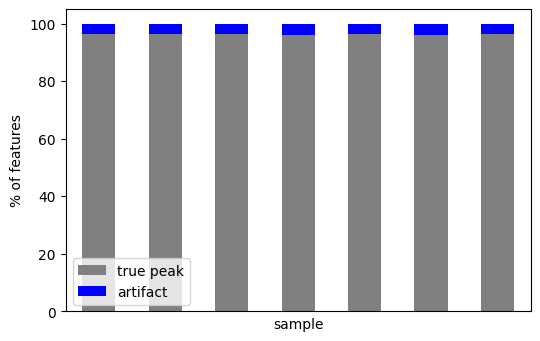

In [36]:
df = {}
for file in files:
    for index,row in peak_curated.iterrows():
        if row[datadir + file] > 0.5:
            df[len(df)] = {"sample":file,"classification":"true peak"}
        else:
            df[len(df)] = {"sample":file,"classification":"artifact"}

df = pd.DataFrame.from_dict(df,orient="index")

def aggregate(rows,columns,df):
    column_keys = df[columns].unique()
    row_keys = df[rows].unique()

    agg = { key : [ 100*len(df[(df[rows]==value) & (df[columns]==key)]) / len(df[df[rows]==value]) for value in row_keys]
               for key in column_keys }

    aggdf = pd.DataFrame(agg,index = row_keys)
    aggdf.index.rename(rows,inplace=True)

    return aggdf


aggregate('sample','classification',df).plot(kind='bar',stacked=True,color=["grey","blue"])
plt.xticks([],[])
plt.ylabel("% of features")

['QC_01.mzML', 'QC_02.mzML', 'QC_03.mzML', 'QC_04.mzML', 'QC_05.mzML', 'QC_06.mzML', 'QC_07.mzML']


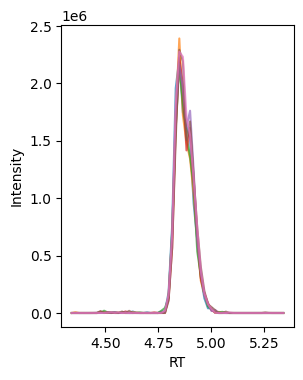

In [37]:
def plot_overlayedEIC(rawdatas,mz,rt_start,rt_end,resolution=60,smoothing=0,alpha=0.3):
    ts = np.linspace(rt_start,rt_end,resolution)
    for data in rawdatas:
        s = data.interpolate_data(mz,rt_start,rt_end,smoothing)
        ints  = [np.max([x,0]) for x in s(ts)]
        plt.plot(ts,ints,alpha=alpha)

file = files[0]
print(files)
inds = list(peak_curated.index.values)
rd.shuffle(inds)
plt.figure(figsize=(3,4))
for i in inds:
    if peak_curated.at[i,datadir + file] > 0.5:
        plot_overlayedEIC(raw_data,peak_curated.at[i,"mz"],peak_curated.at[i,"rt"]-.5,peak_curated.at[i,"rt"]+.5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break

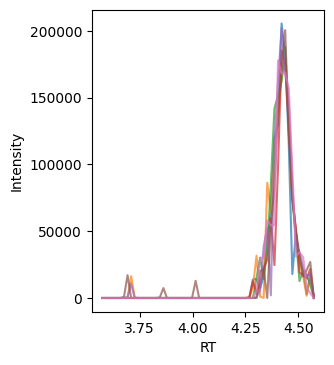

In [39]:
rd.shuffle(inds)
plt.figure(figsize=(3,4))
for i in inds:
    if peak_curated.at[i,datadir + file] < 0.5:
        plot_overlayedEIC(raw_data,peak_curated.at[i,"mz"],peak_curated.at[i,"rt"]-.5,peak_curated.at[i,"rt"]+.5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break

In [40]:
true = []
pred = []
file = files[0]
fps = []
fns = []
for index,row in peakList_labeled.iterrows():
    if peak_curated.at[index,datadir + file] > 0.5:
        pred.append(1.0)
        if row["classification"] < 0.5:
            fps.append(index)
    else:
        pred.append(0.0)
        if row["classification"] > .5:
            fns.append(index)
    true.append(row["classification"])
    
confusion_matrix(true,pred)

array([[ 12, 155],
       [  4, 329]], dtype=int64)

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


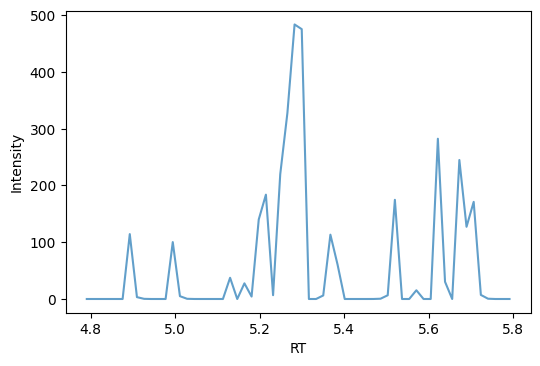

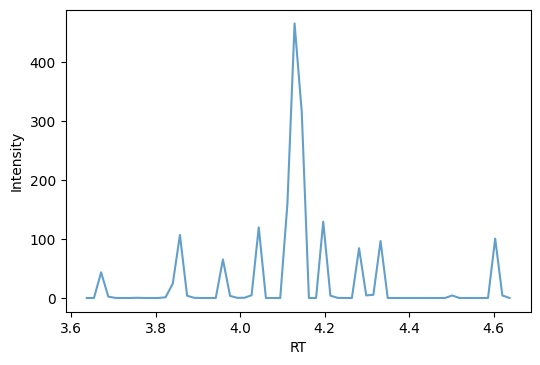

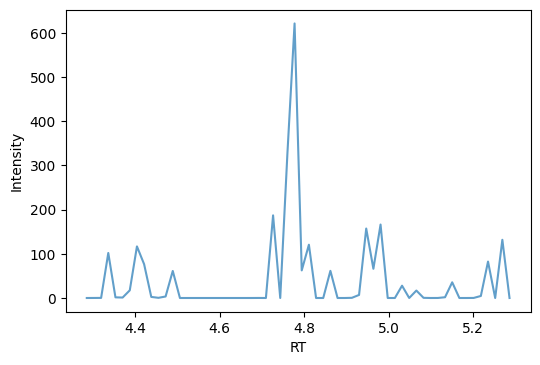

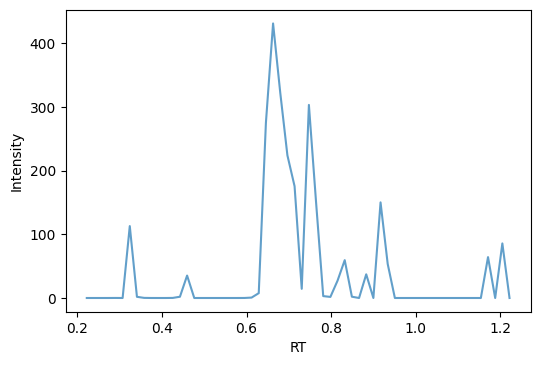

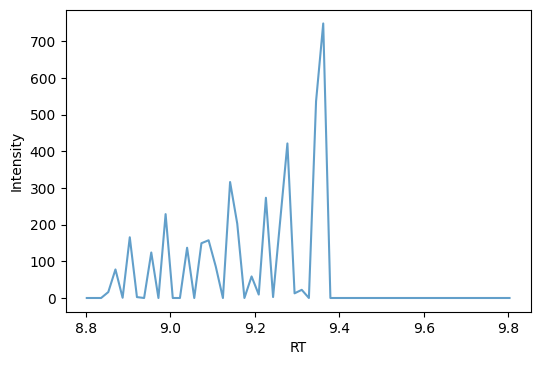

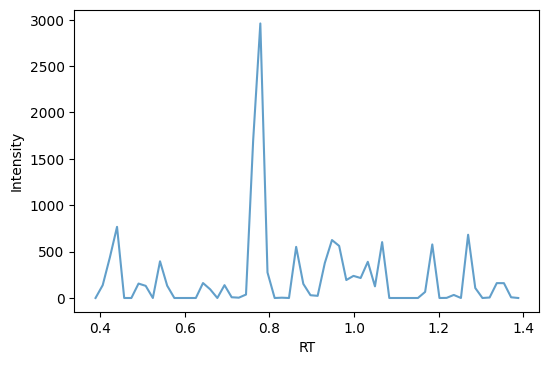

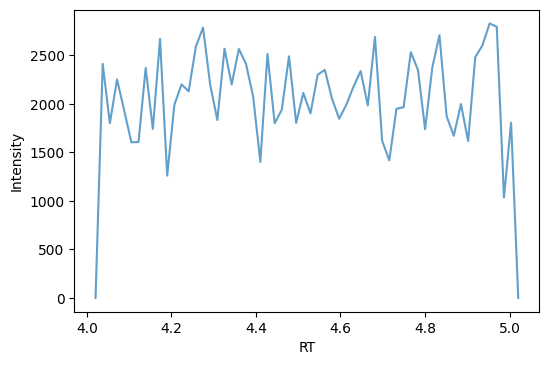

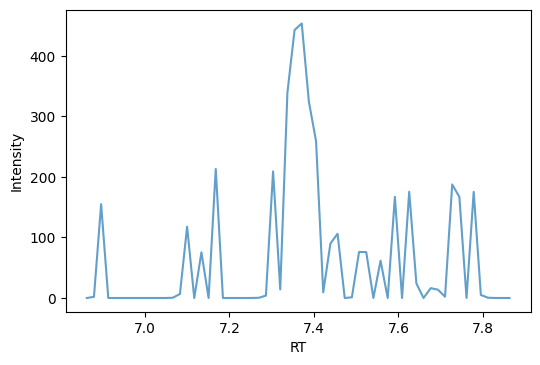

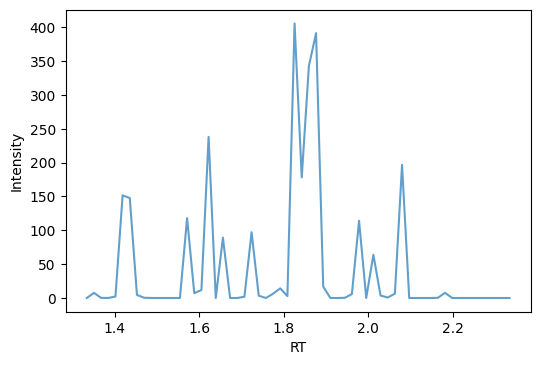

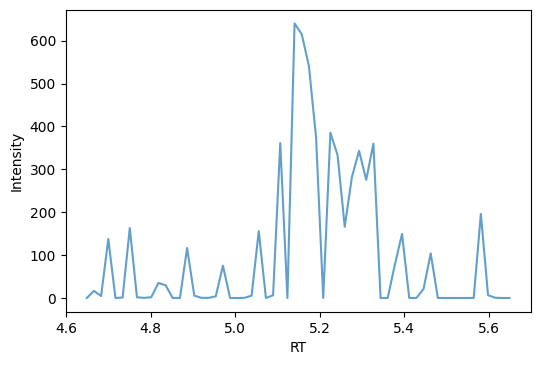

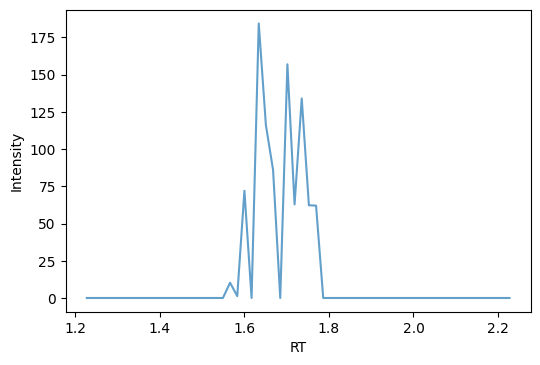

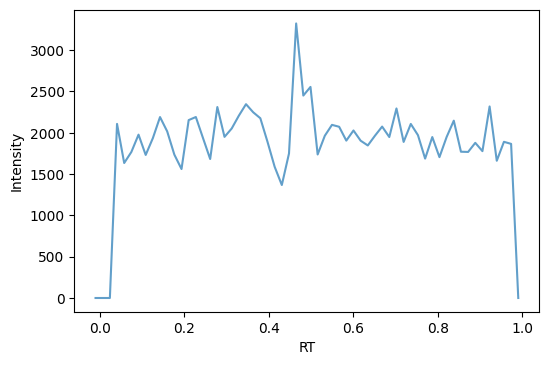

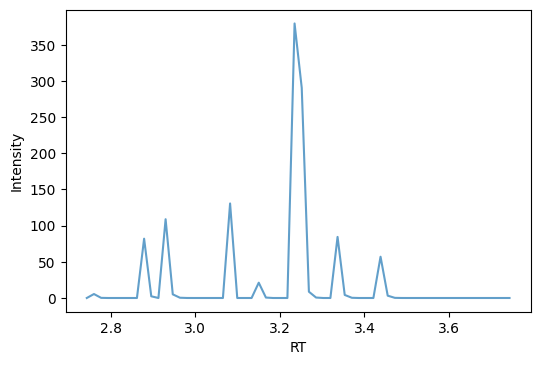

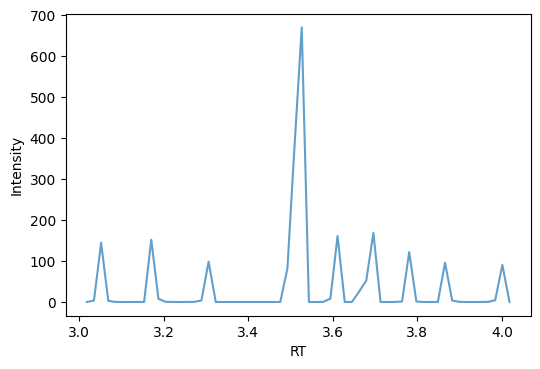

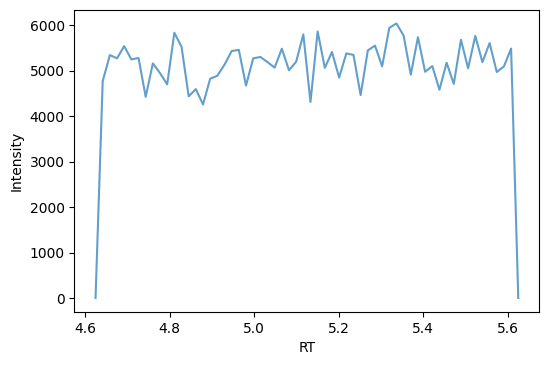

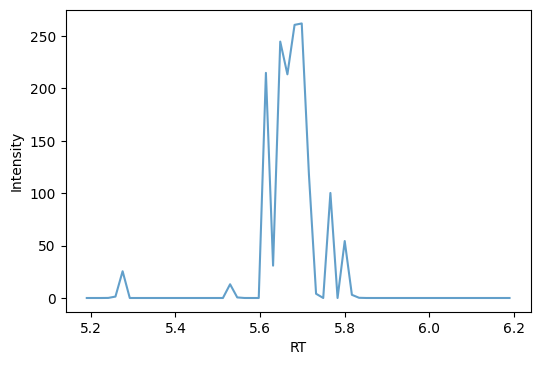

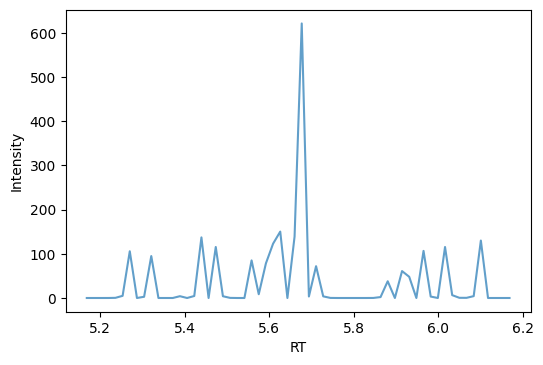

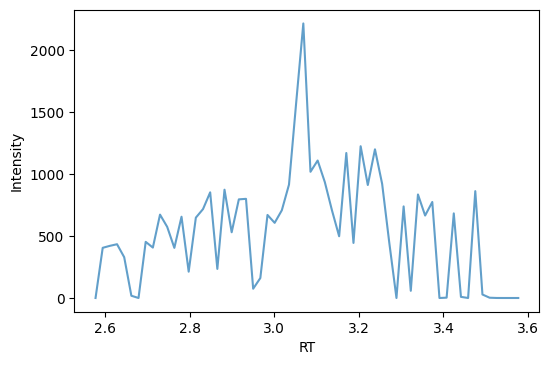

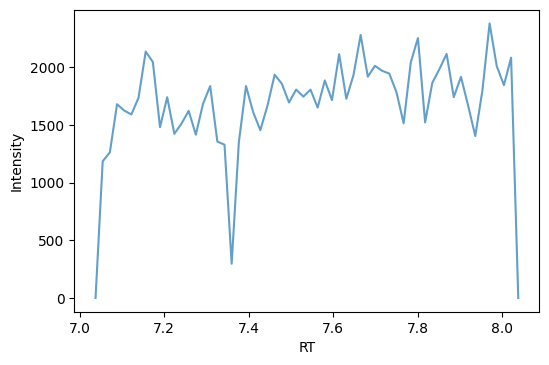

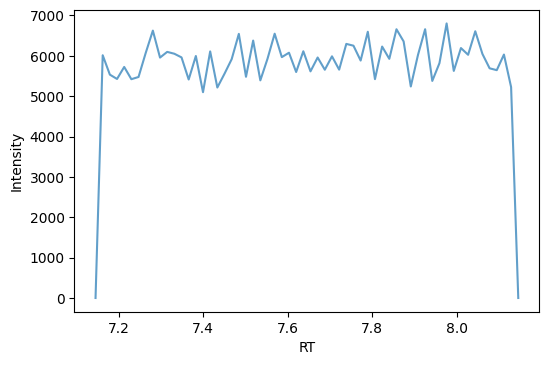

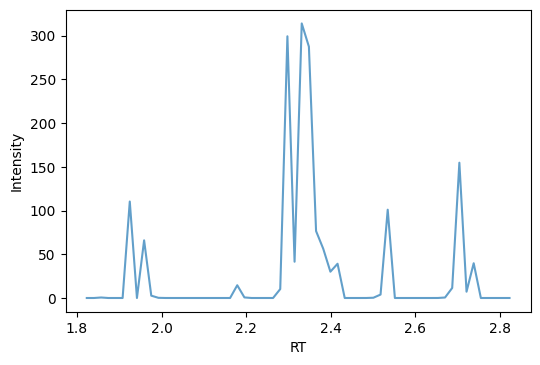

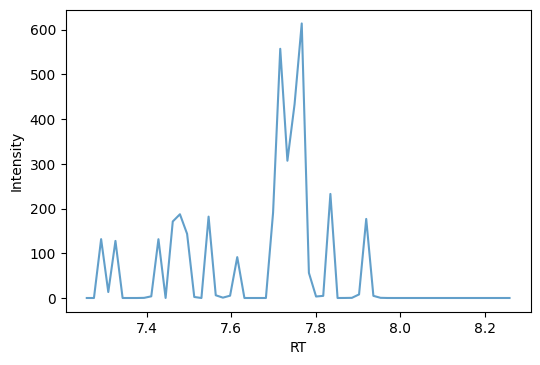

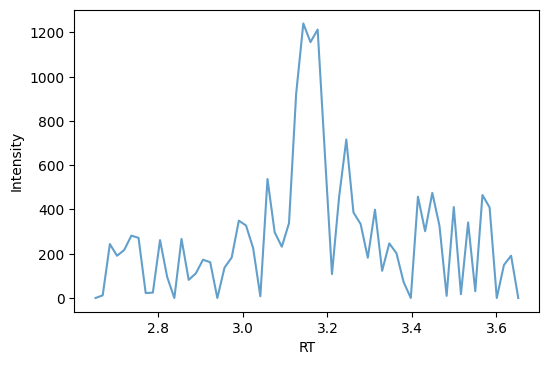

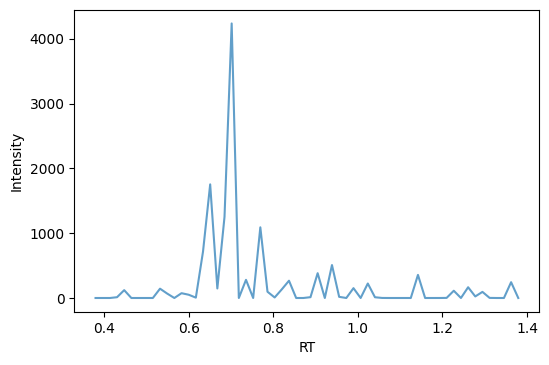

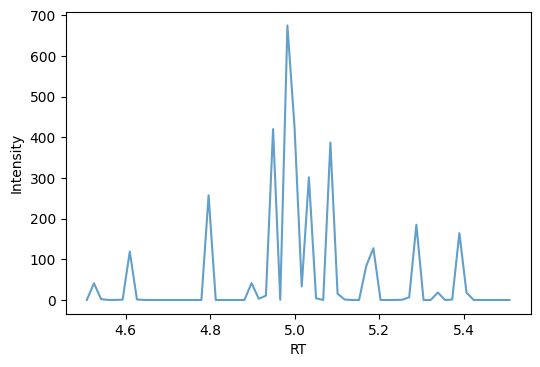

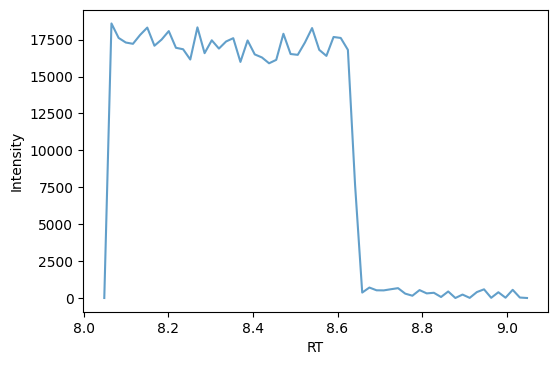

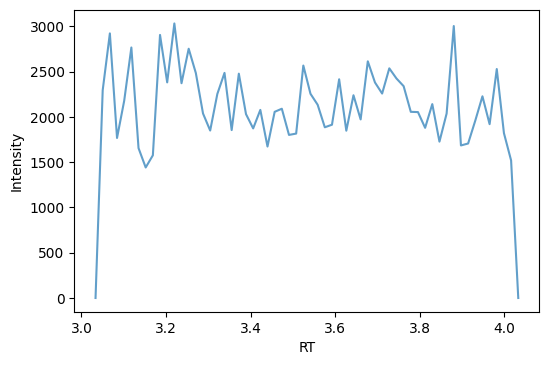

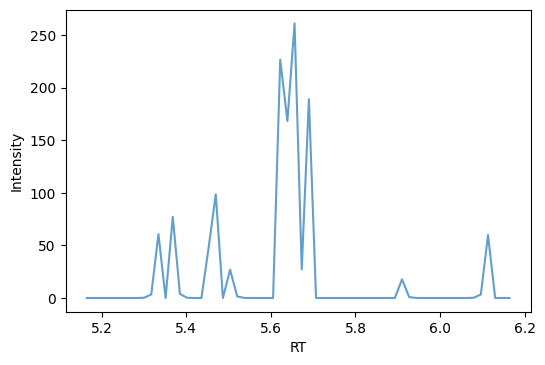

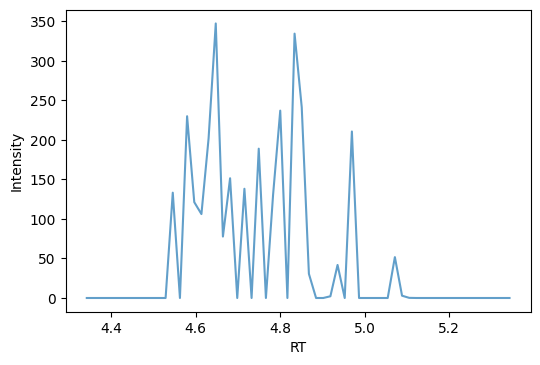

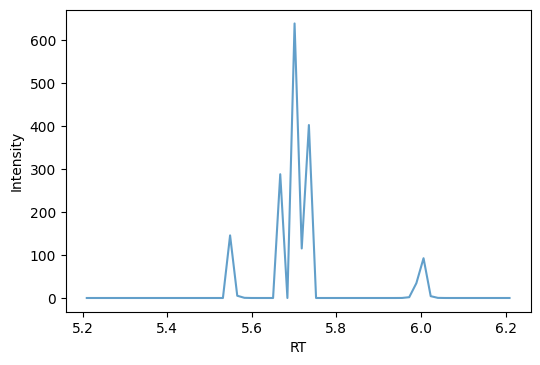

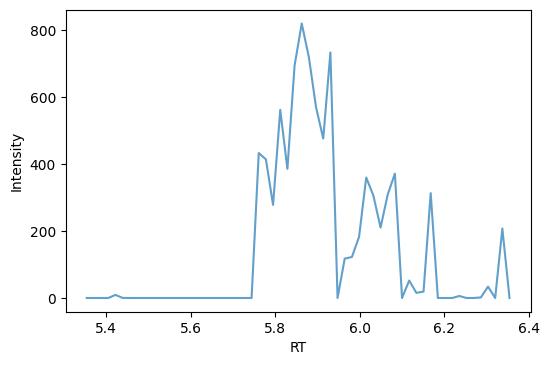

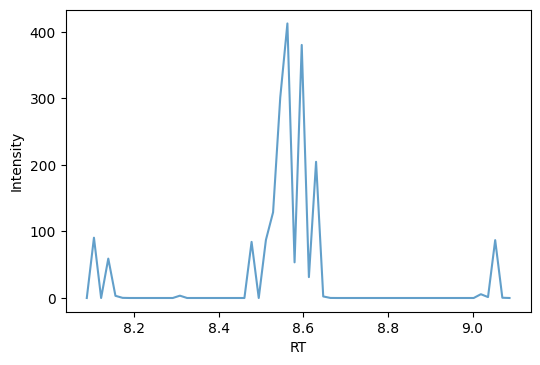

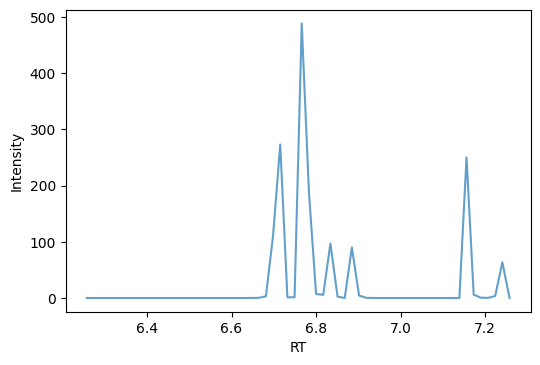

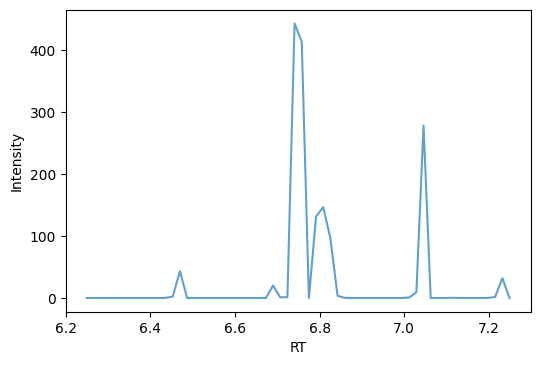

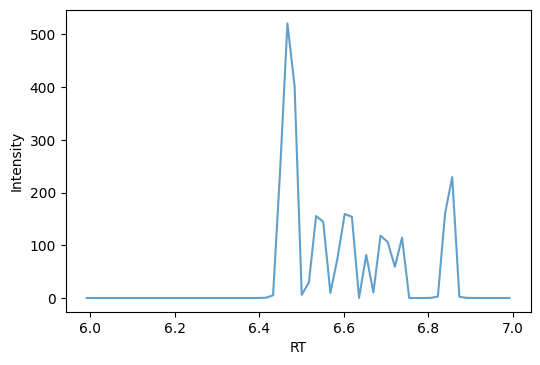

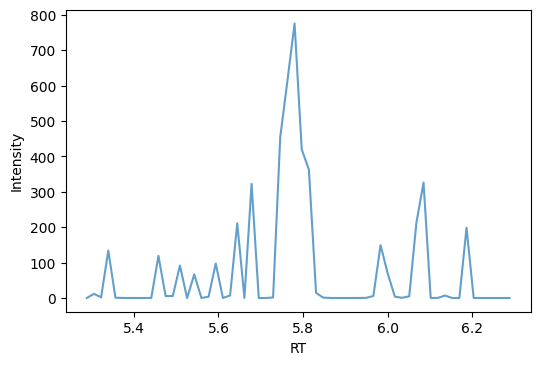

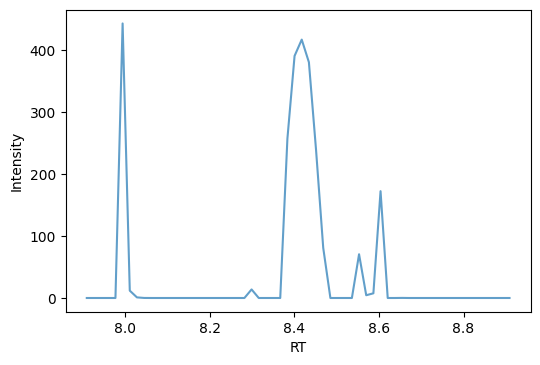

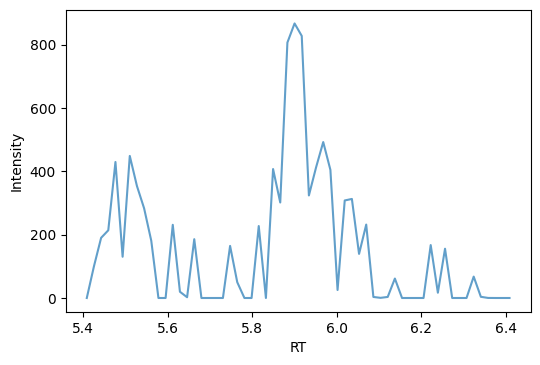

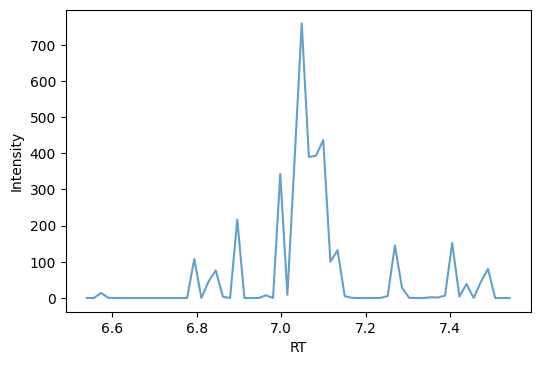

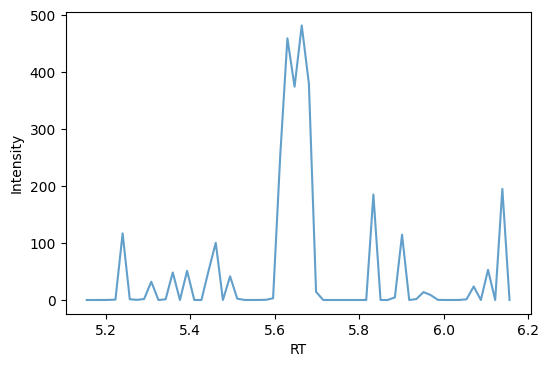

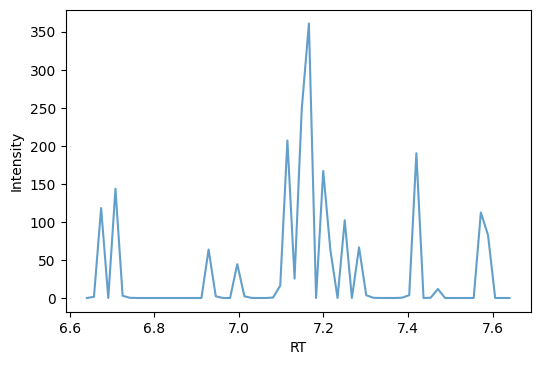

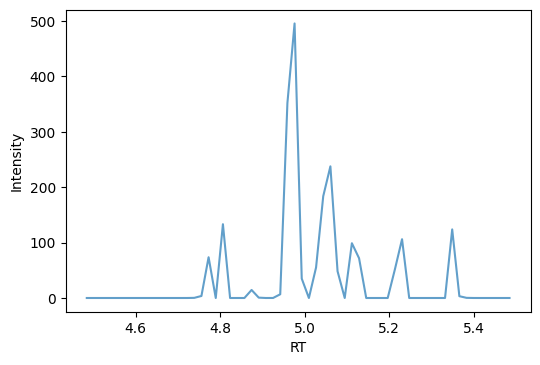

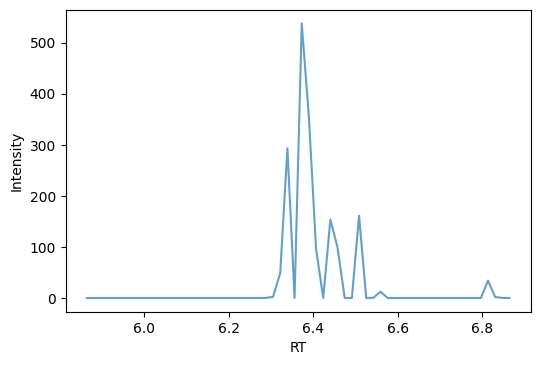

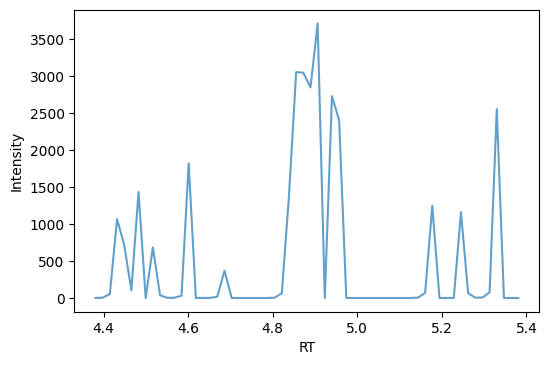

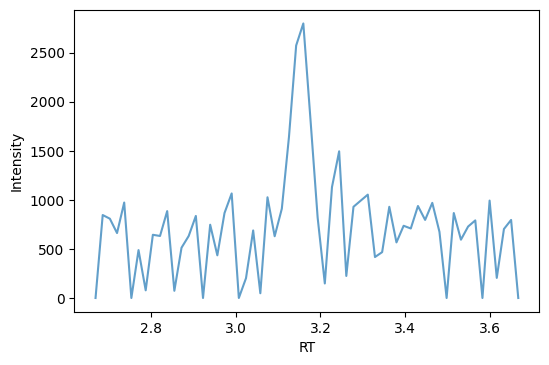

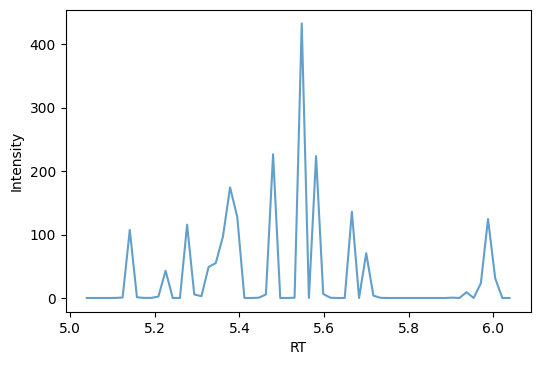

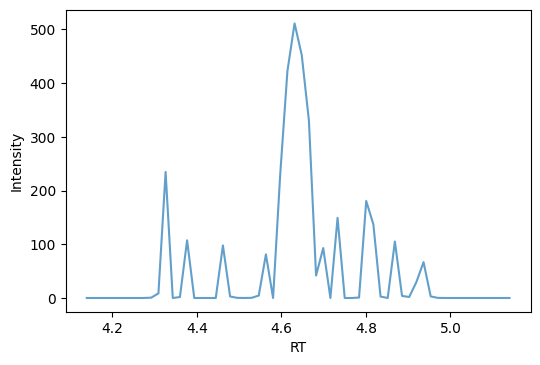

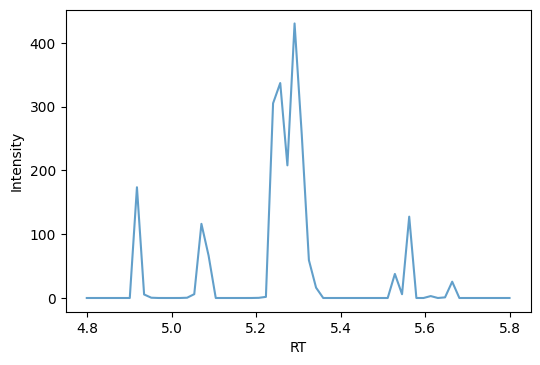

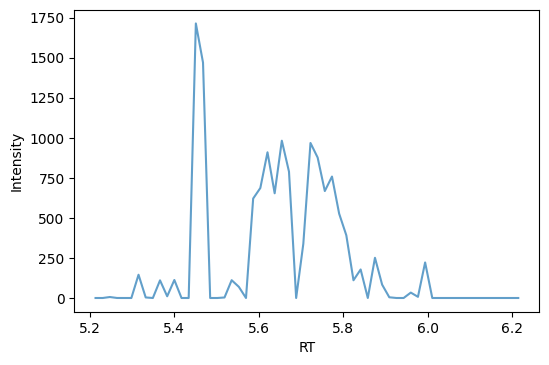

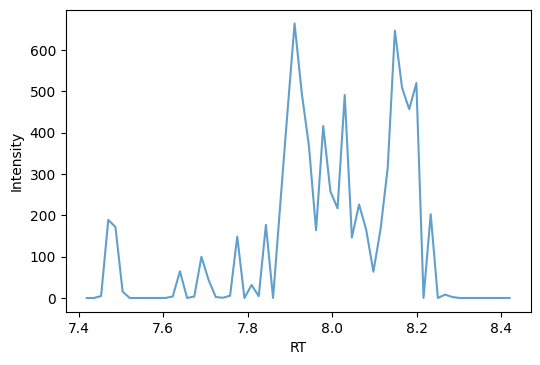

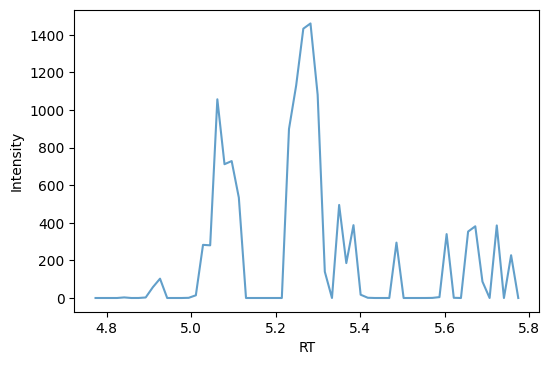

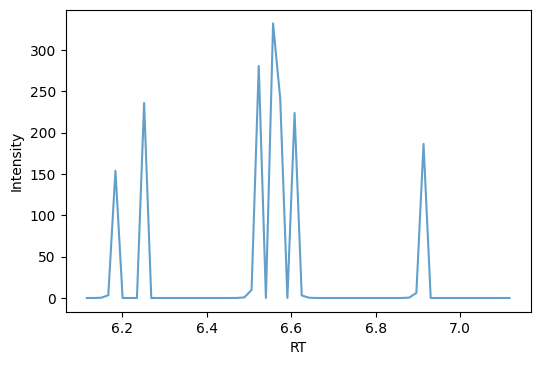

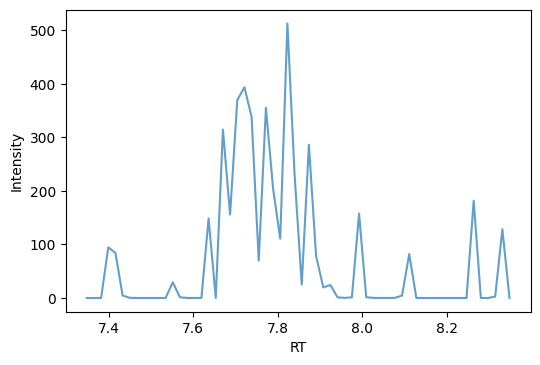

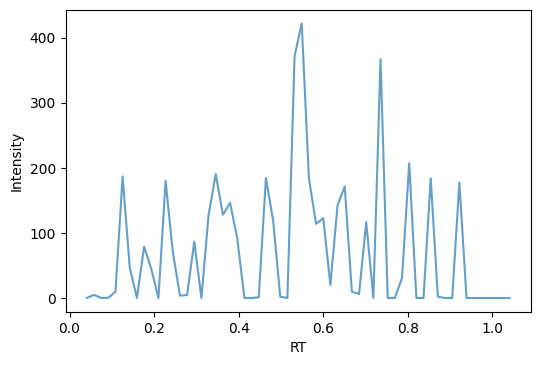

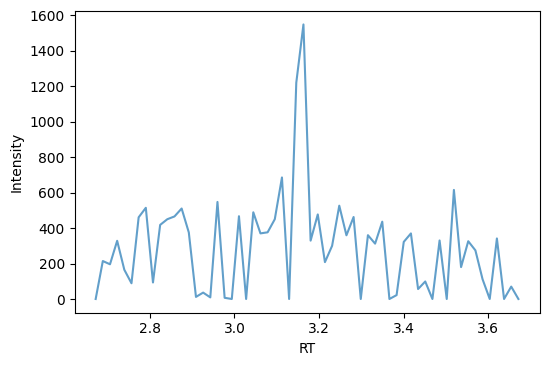

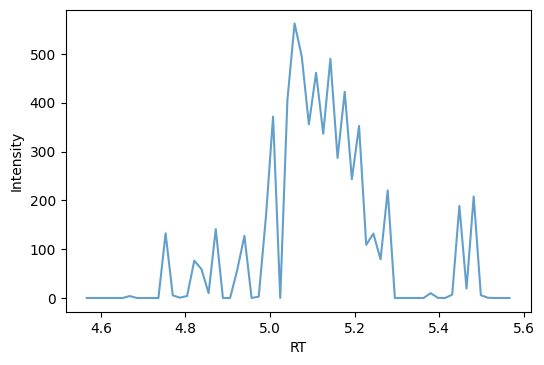

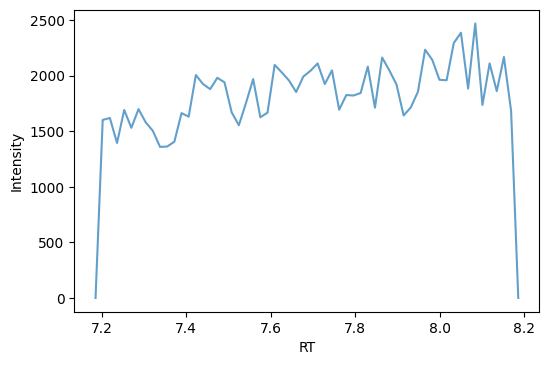

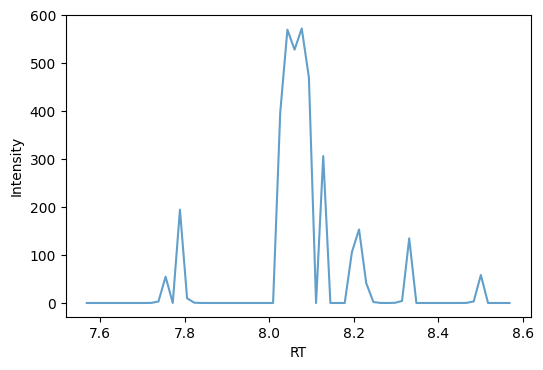

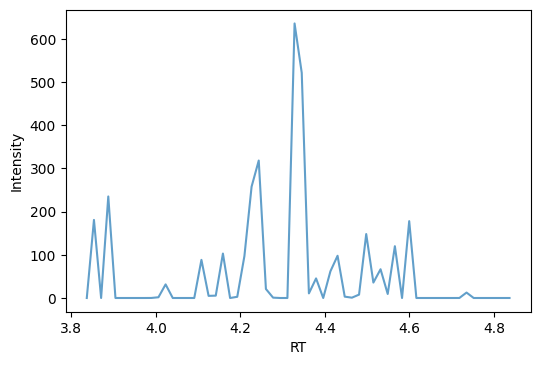

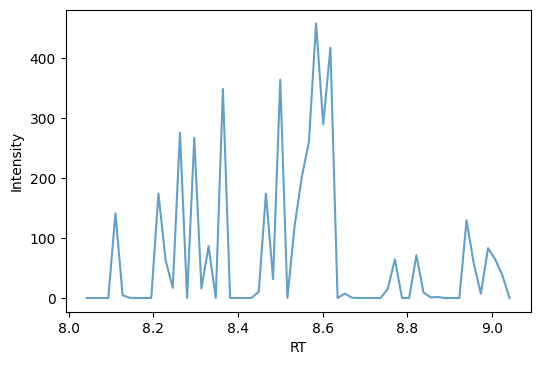

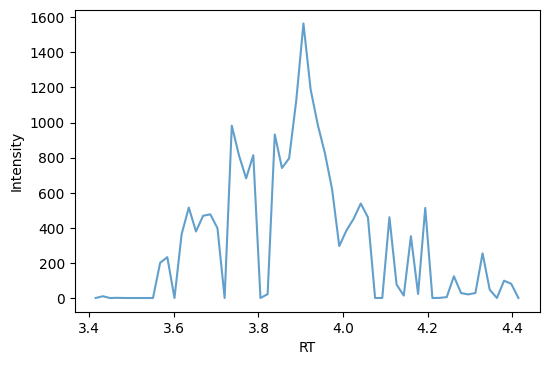

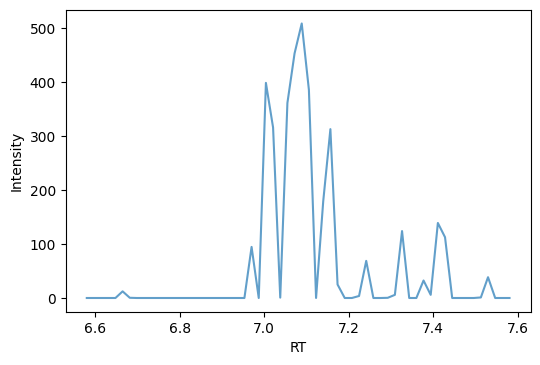

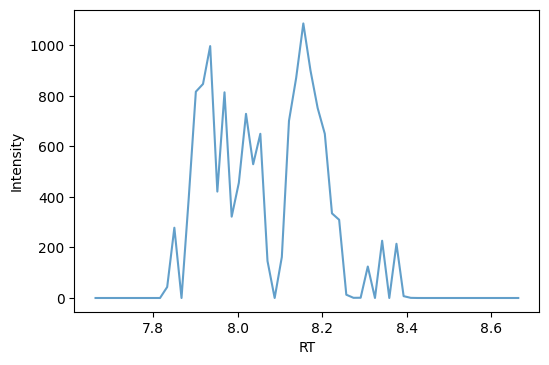

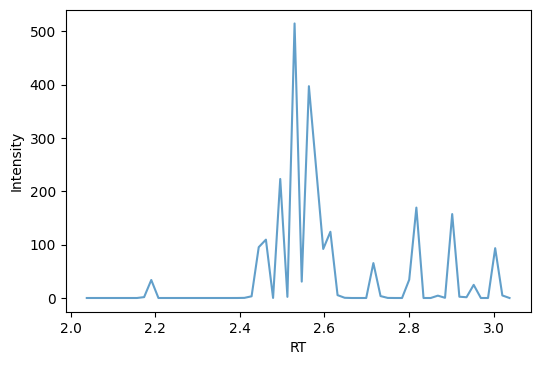

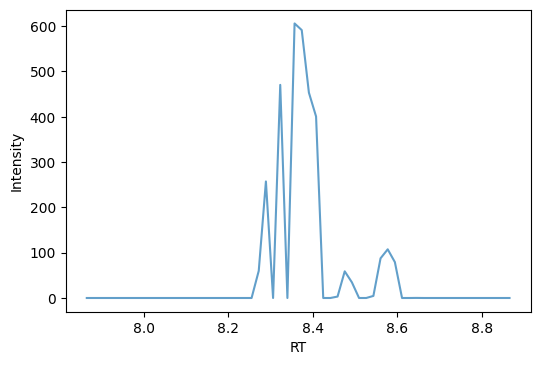

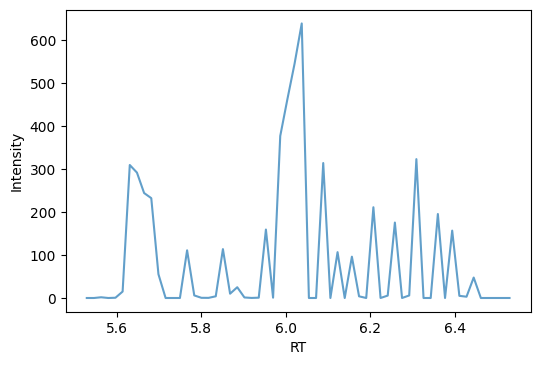

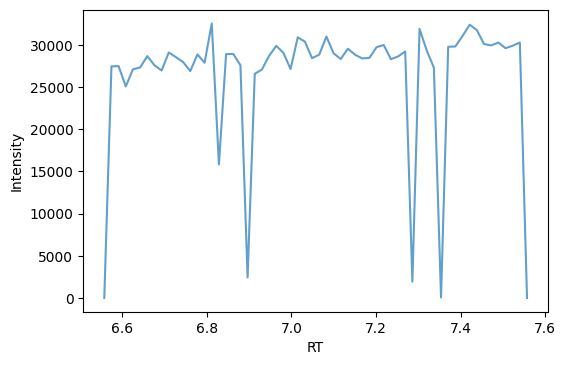

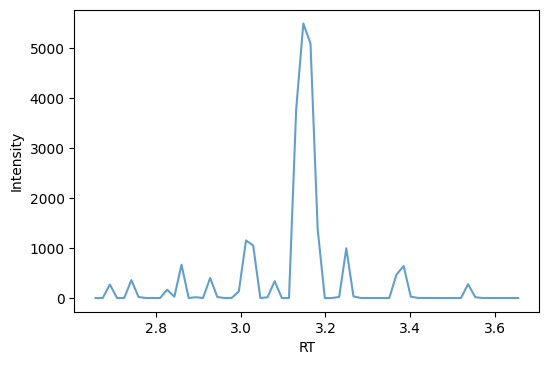

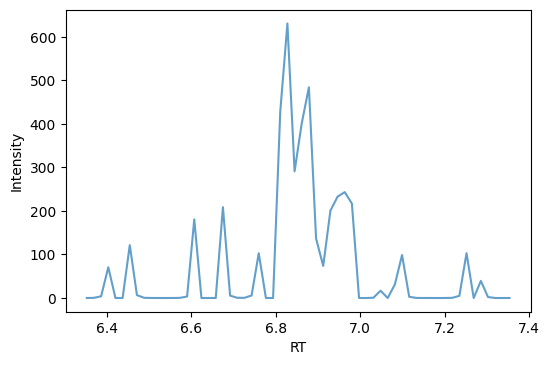

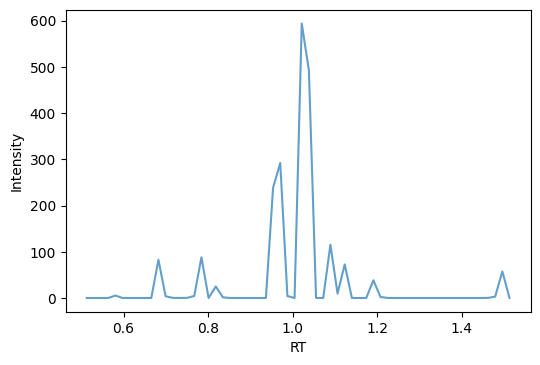

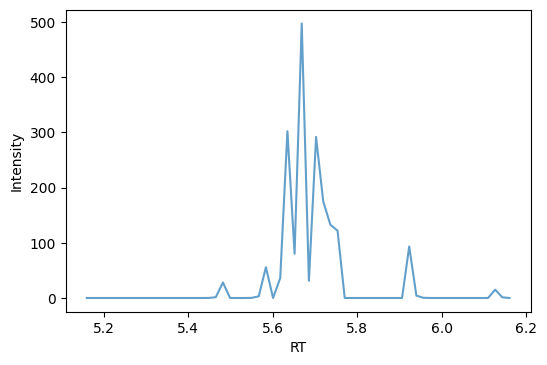

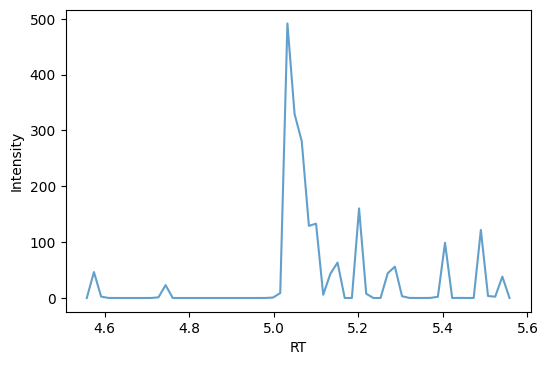

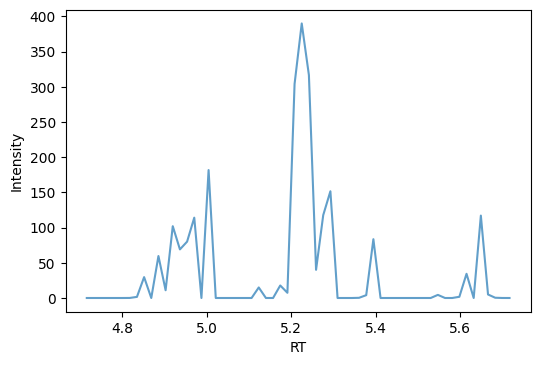

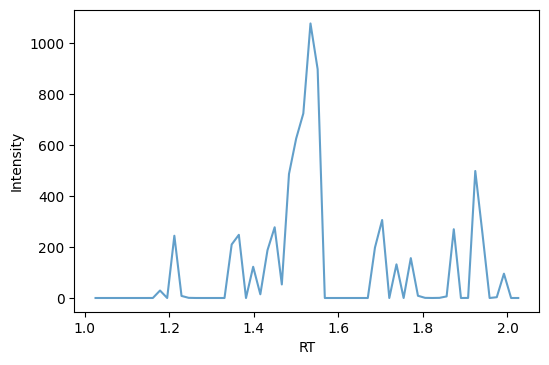

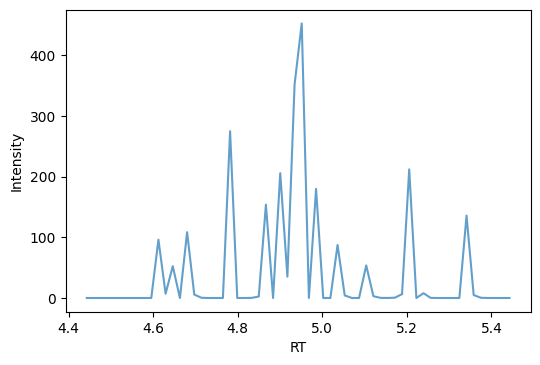

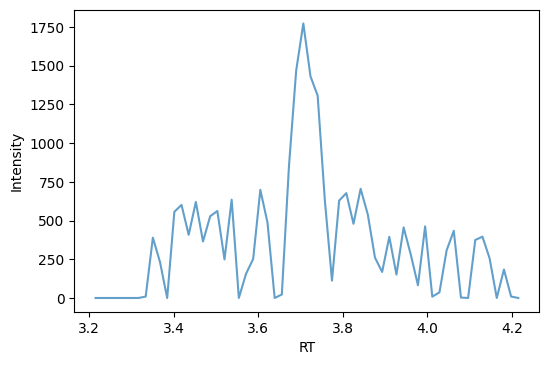

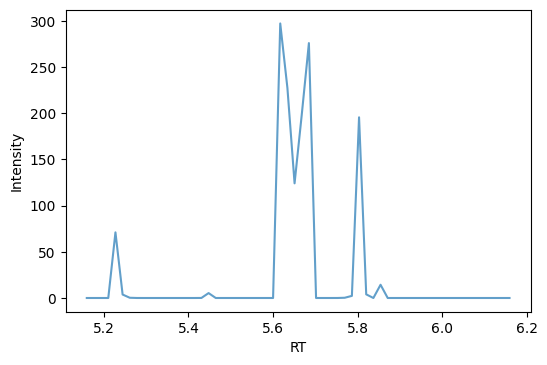

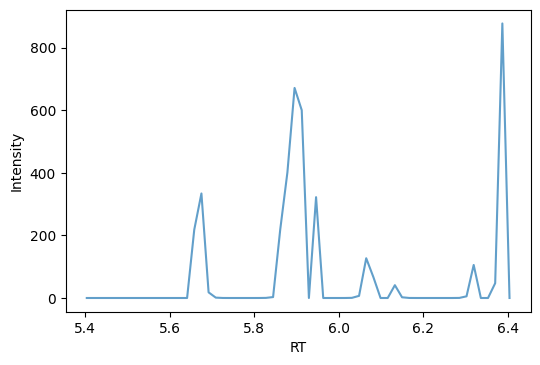

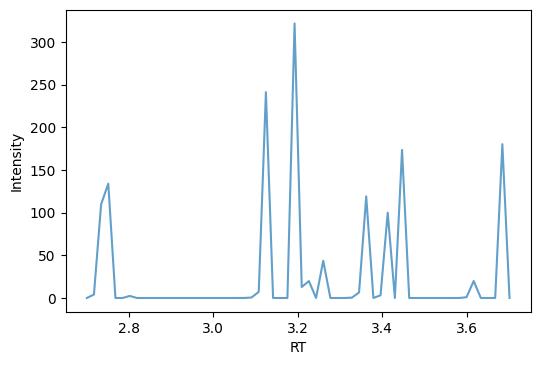

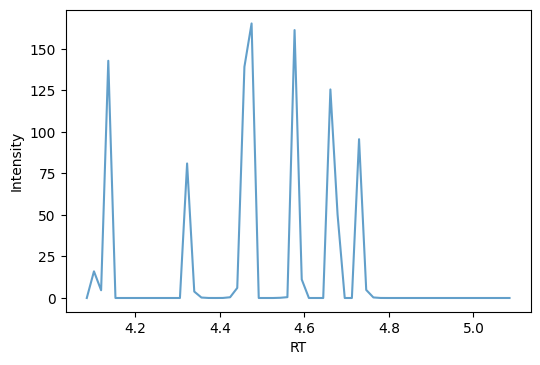

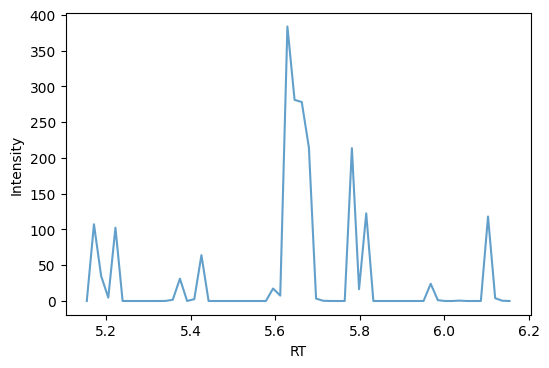

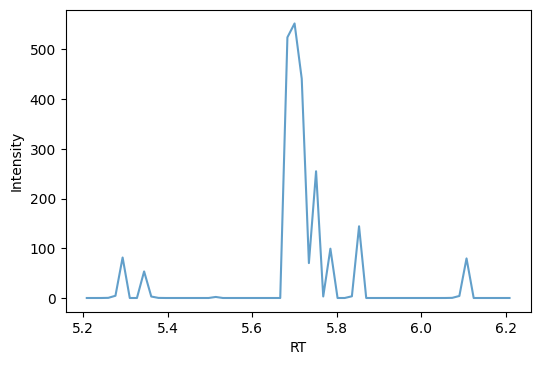

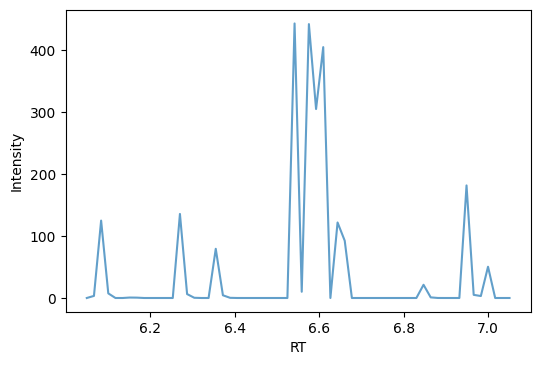

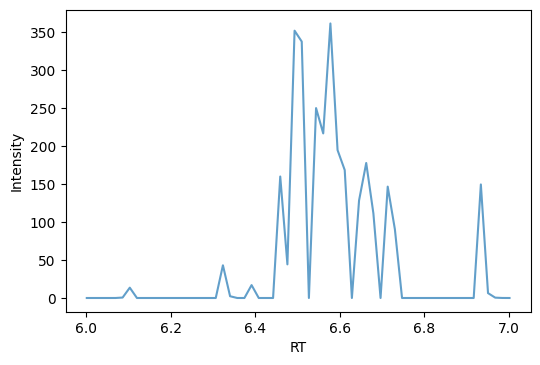

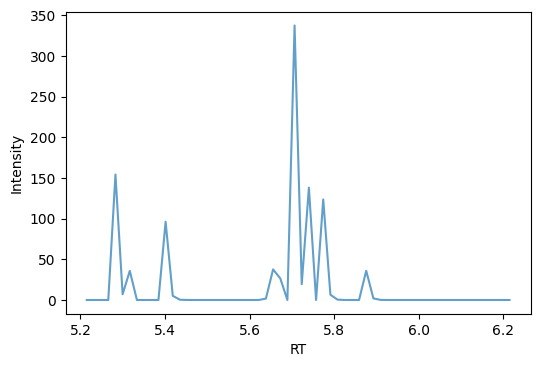

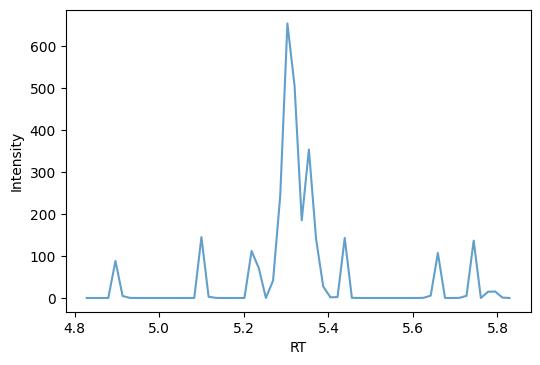

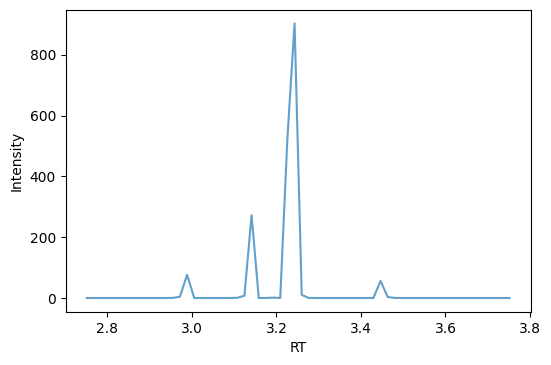

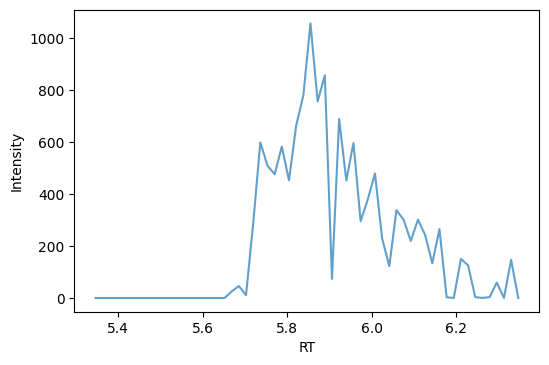

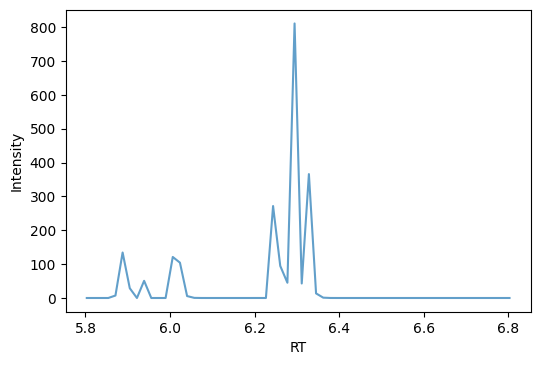

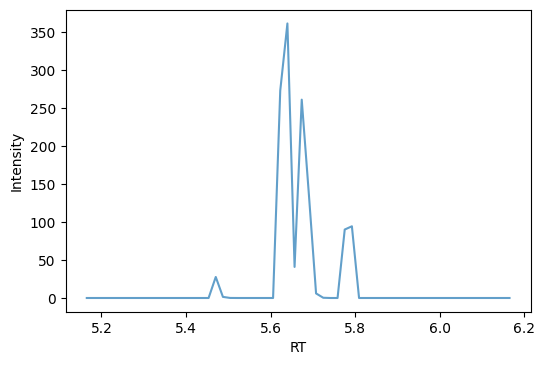

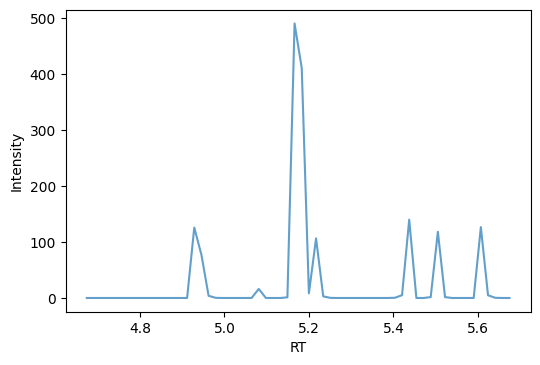

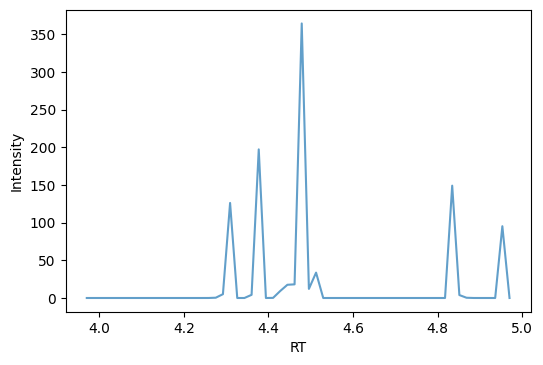

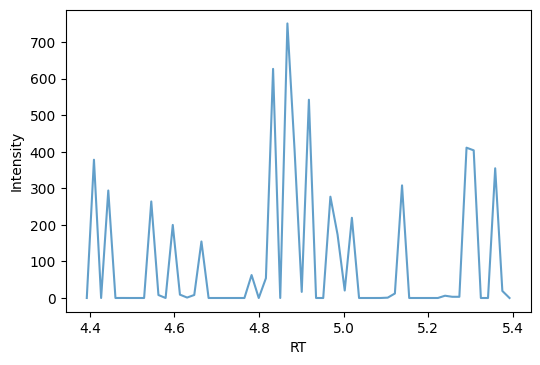

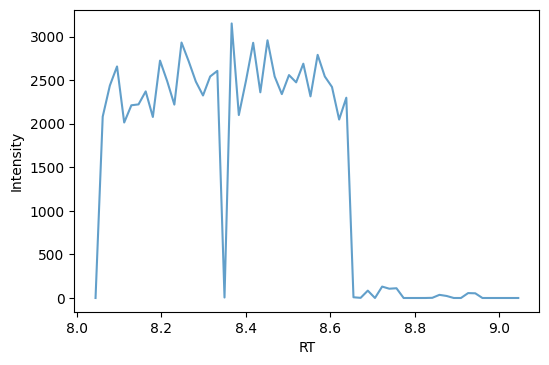

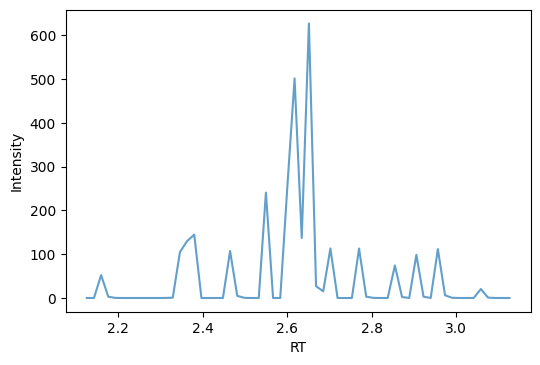

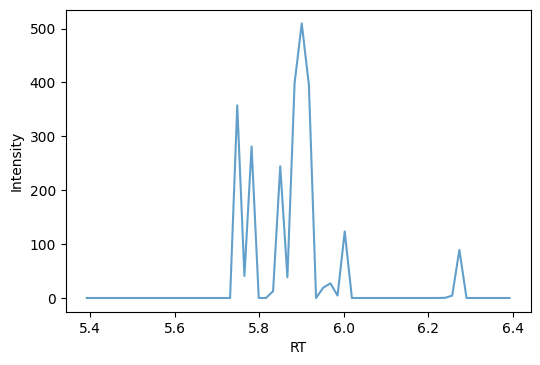

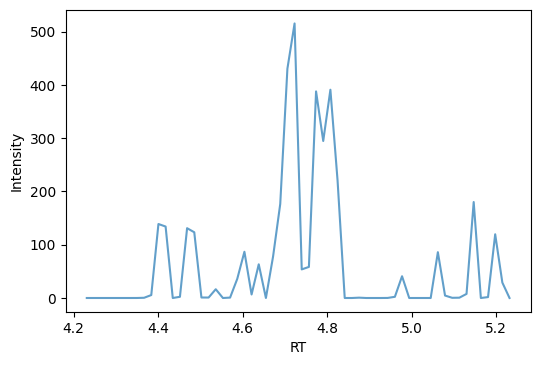

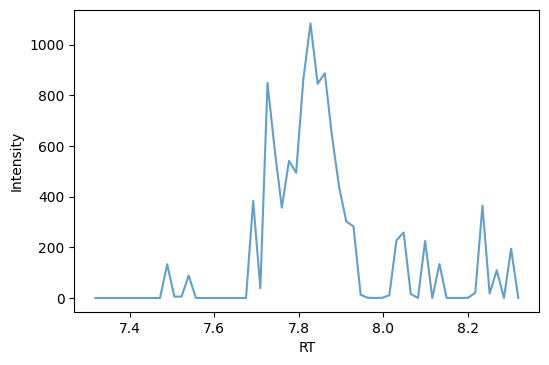

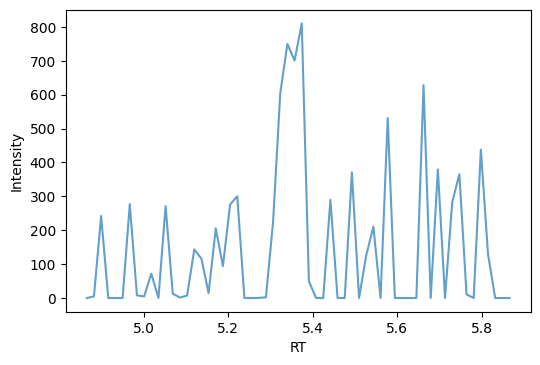

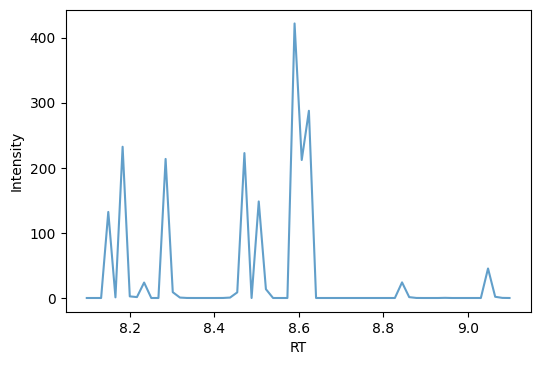

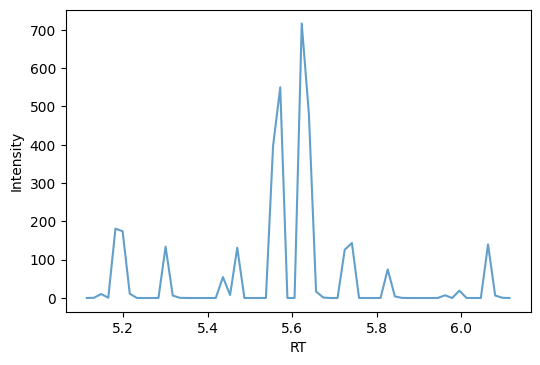

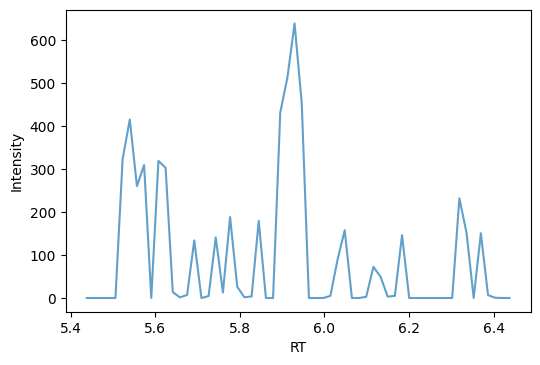

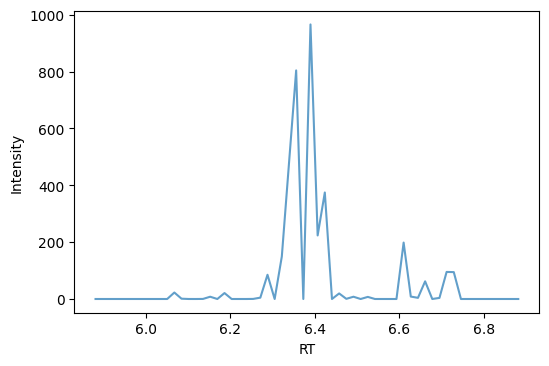

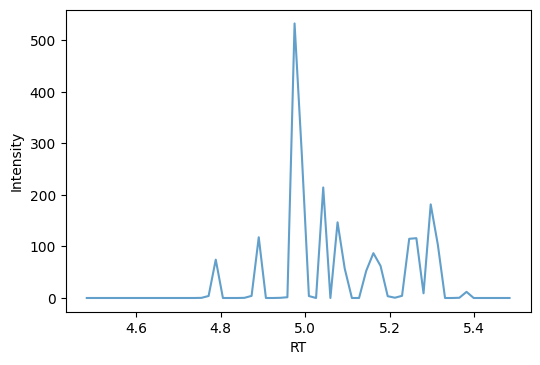

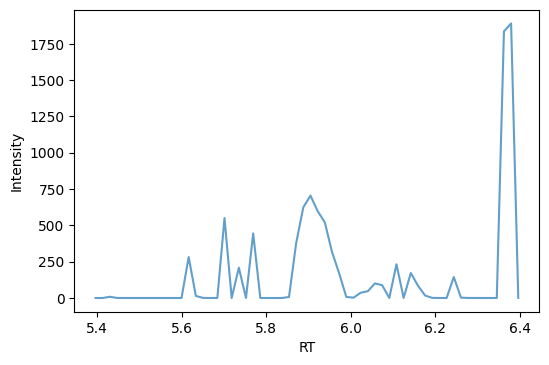

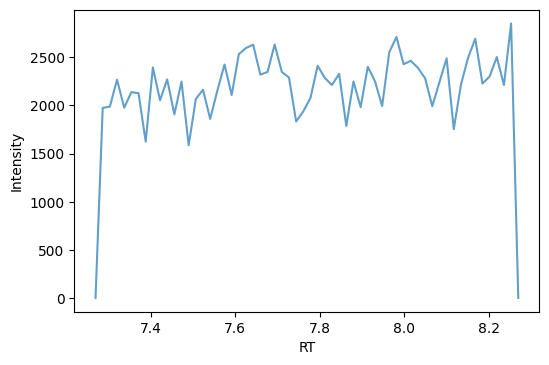

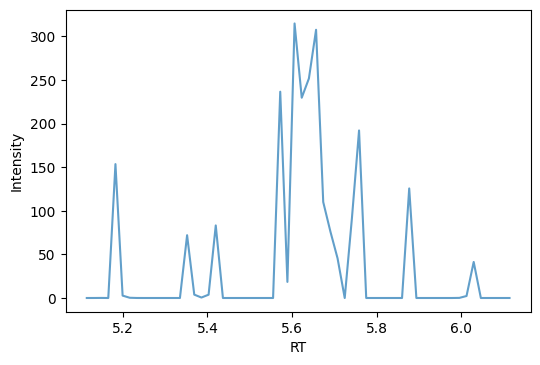

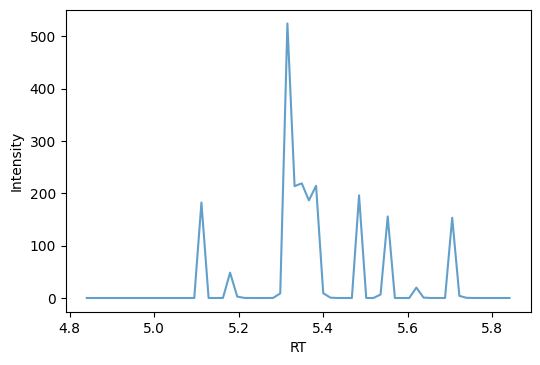

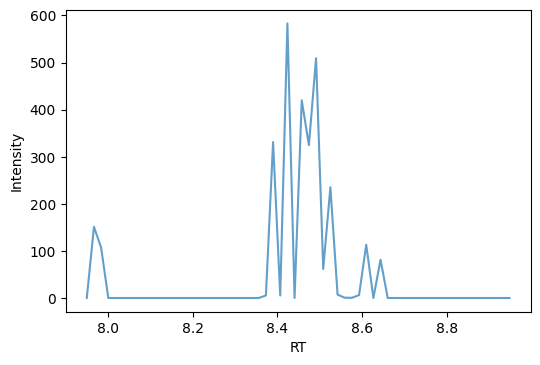

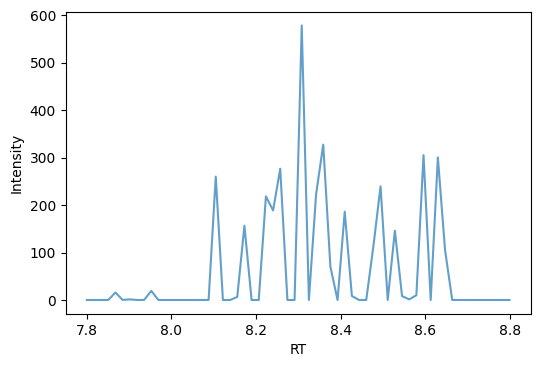

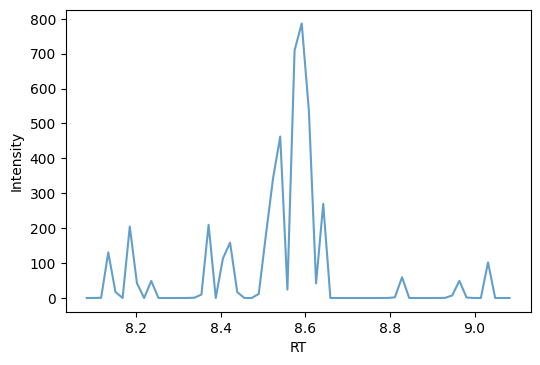

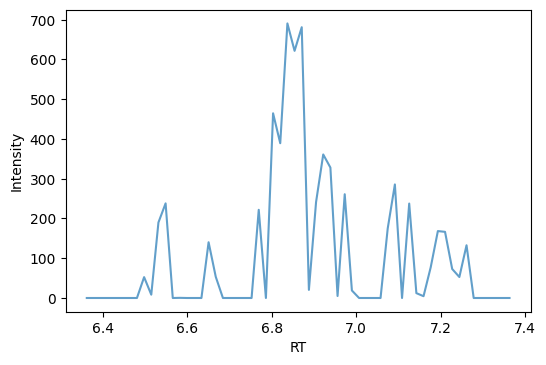

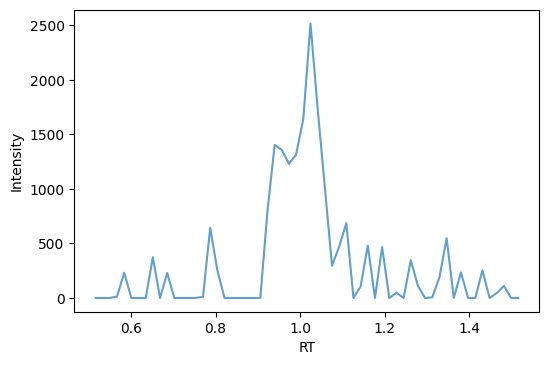

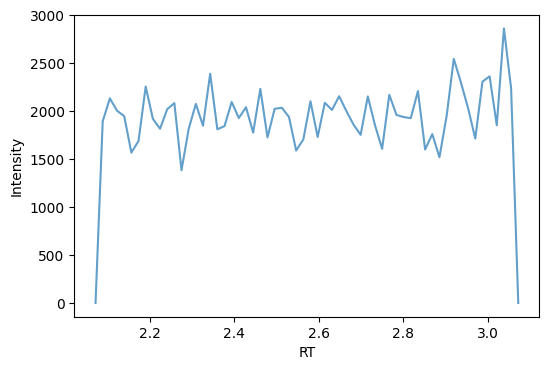

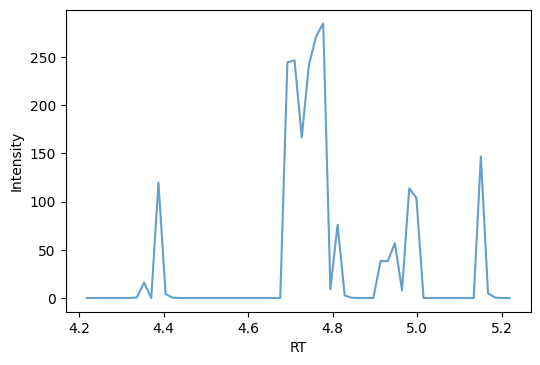

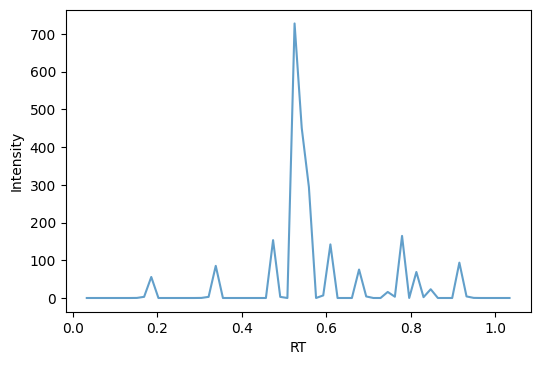

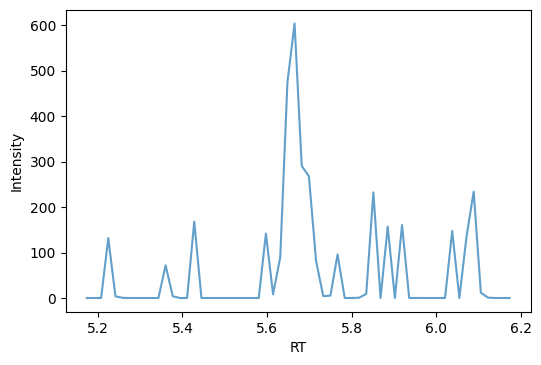

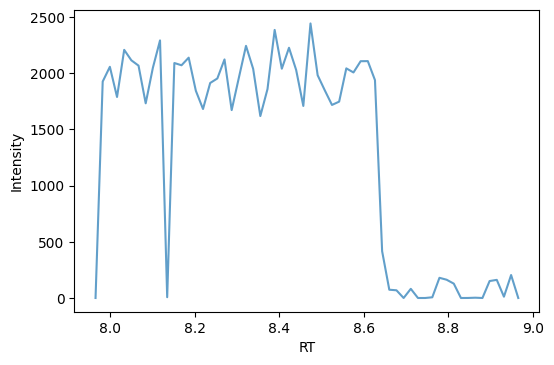

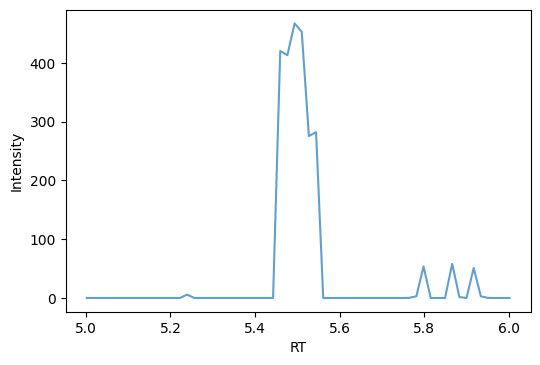

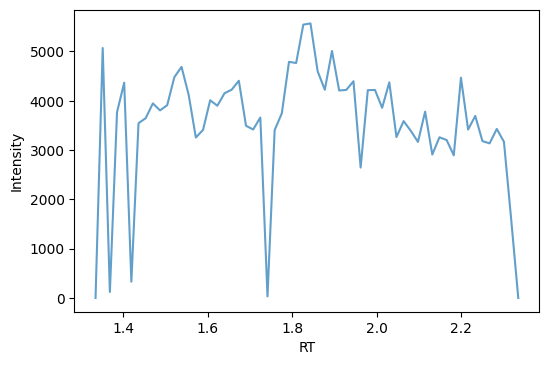

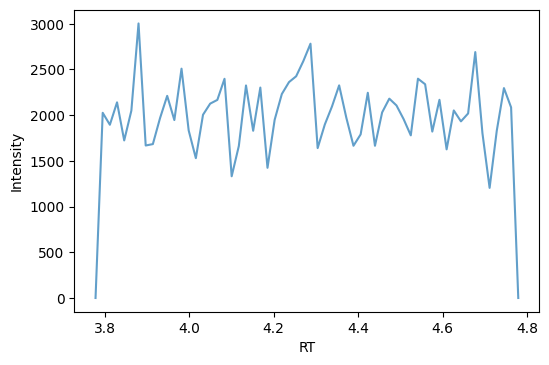

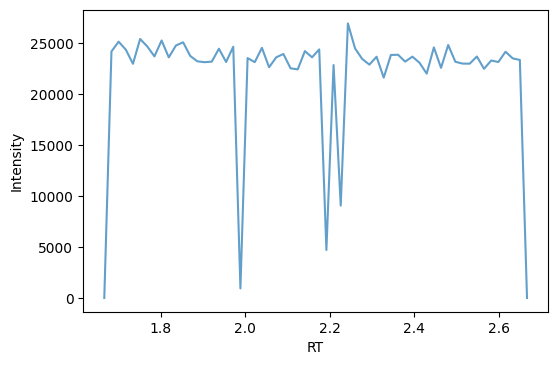

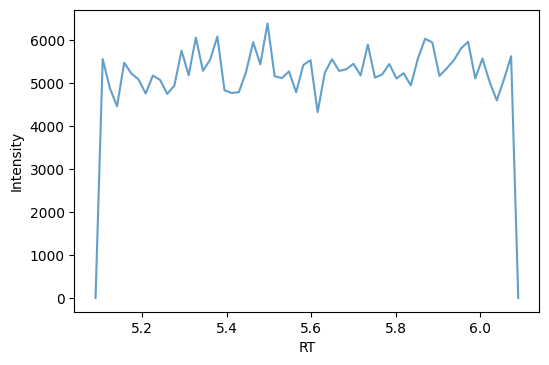

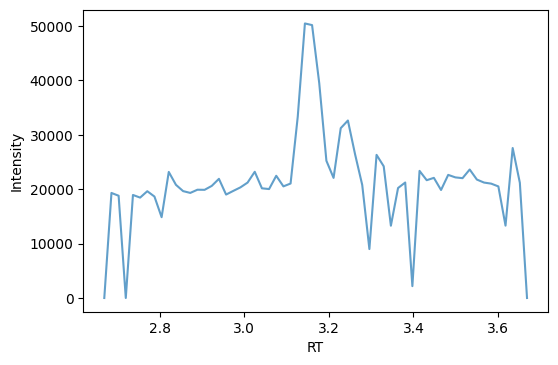

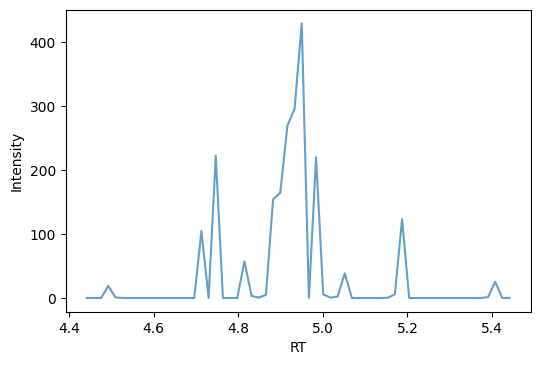

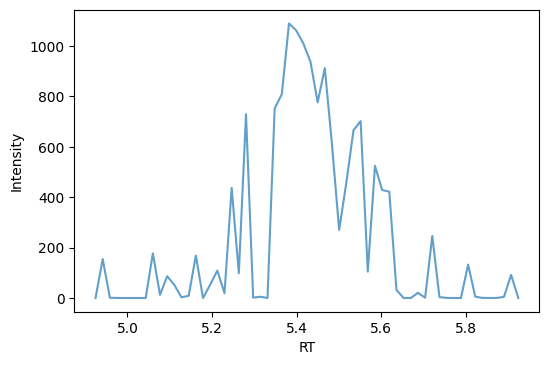

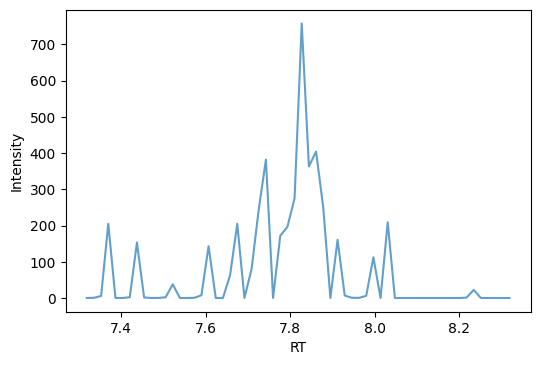

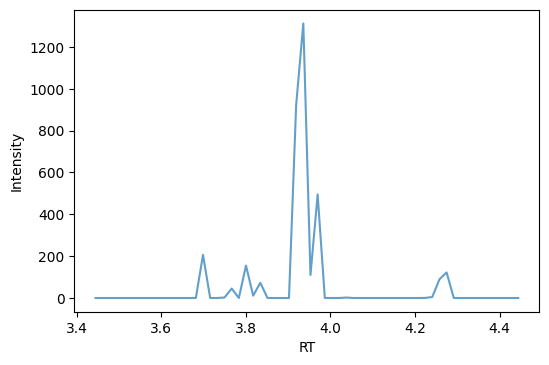

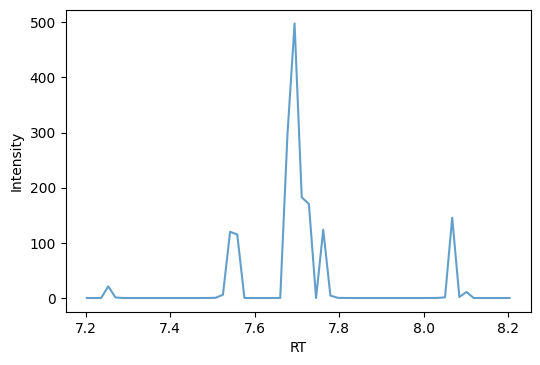

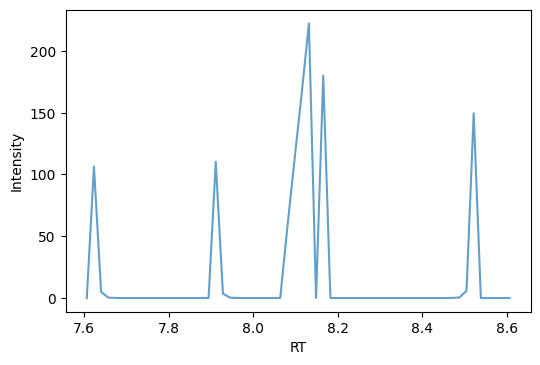

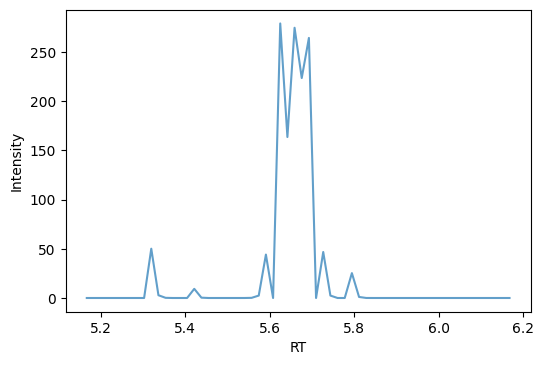

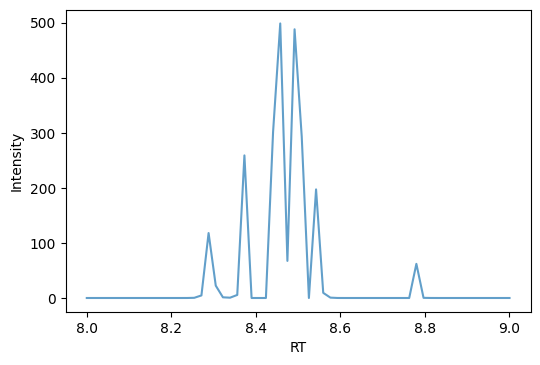

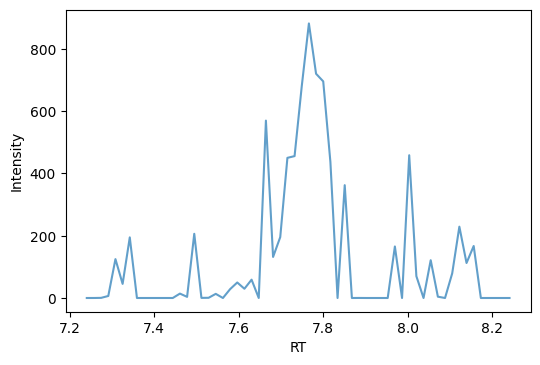

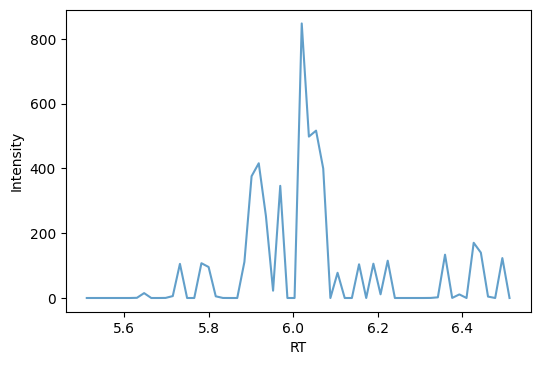

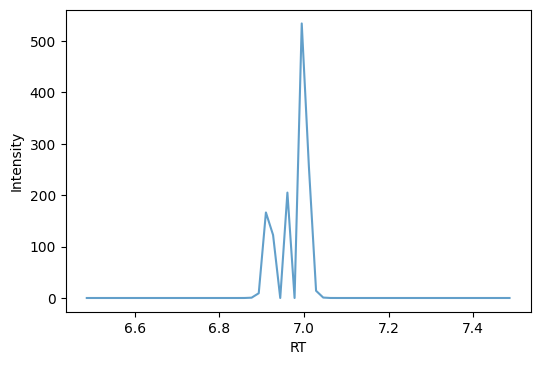

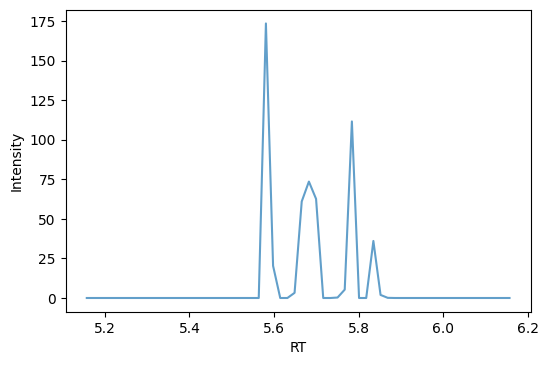

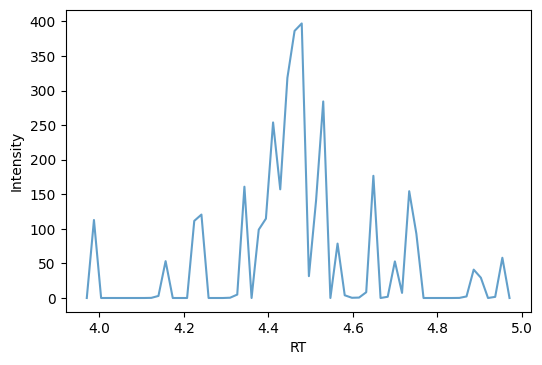

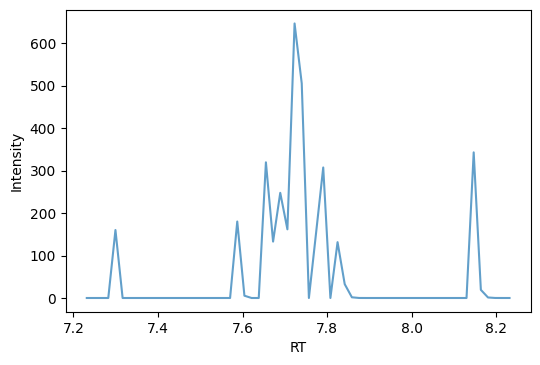

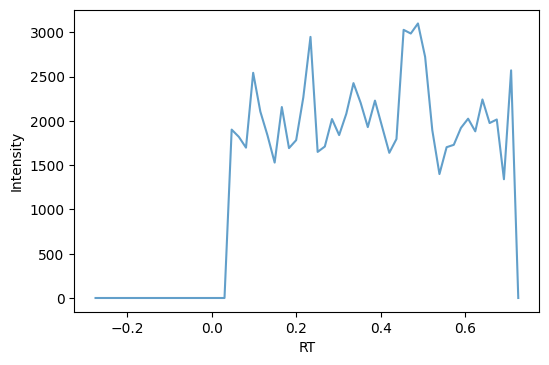

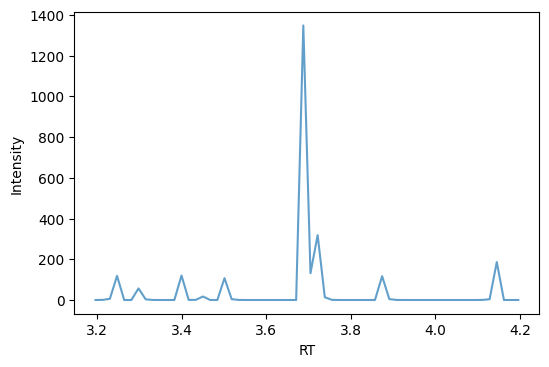

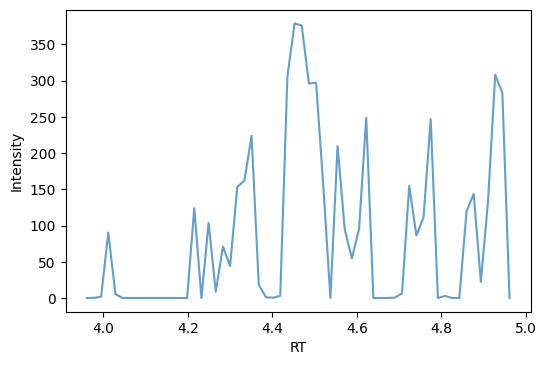

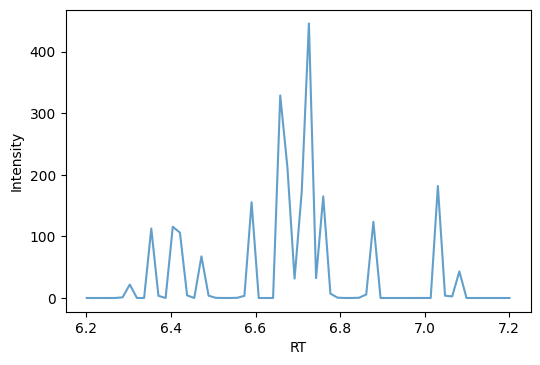

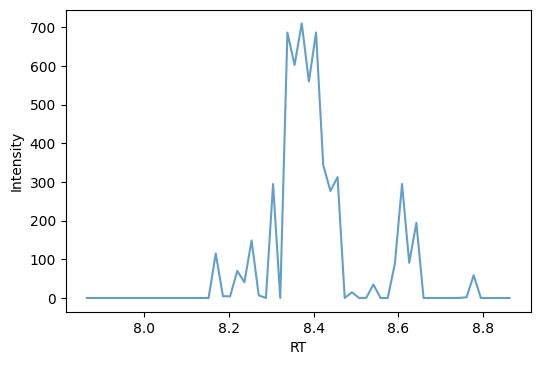

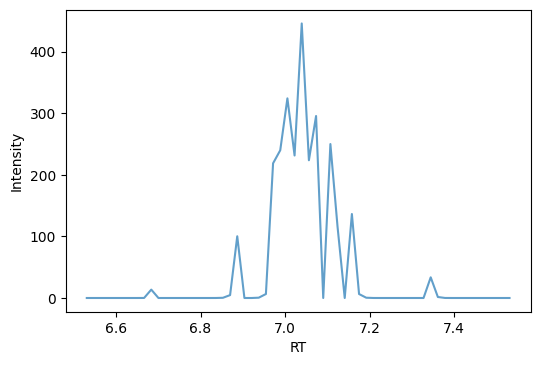

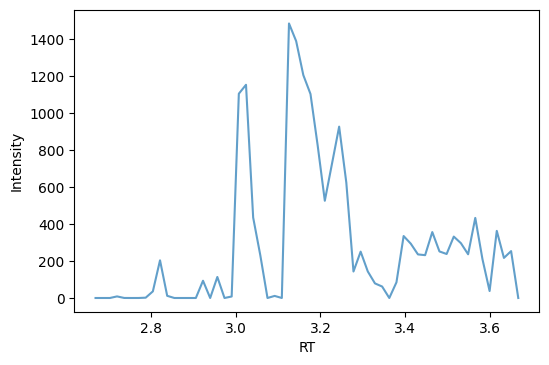

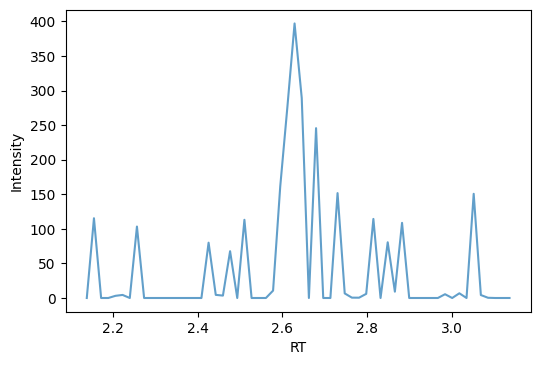

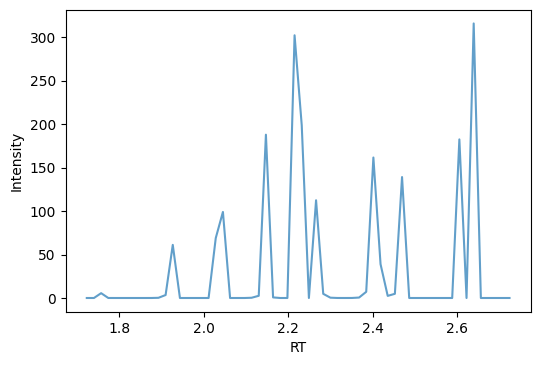

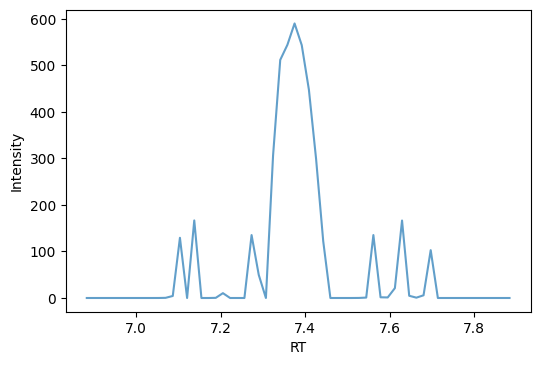

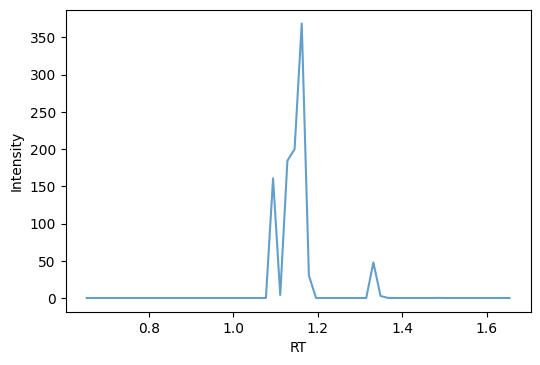

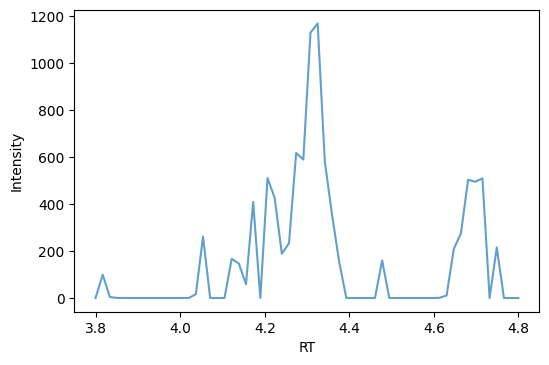

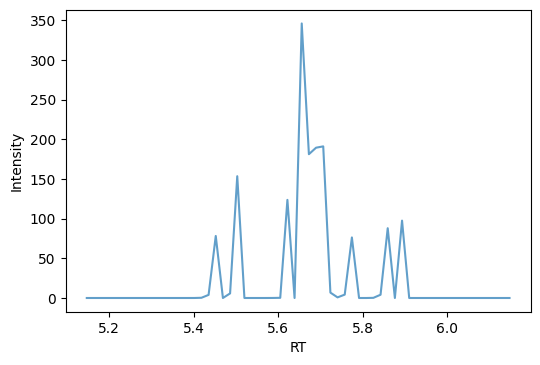

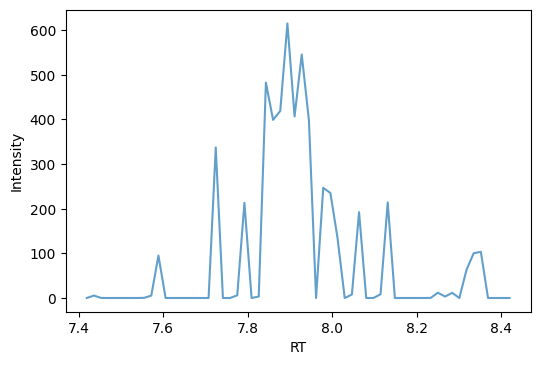

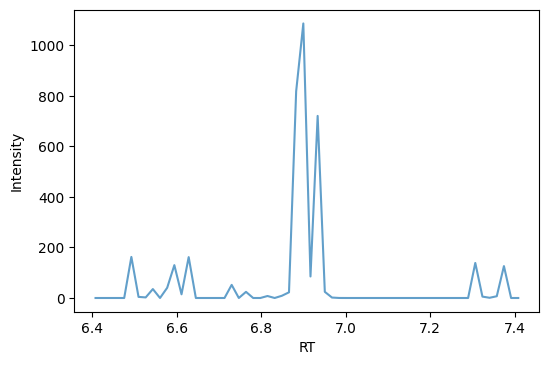

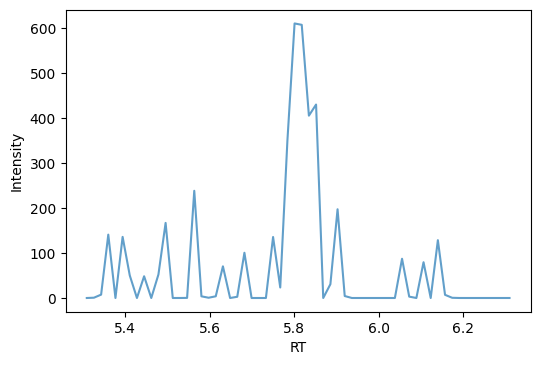

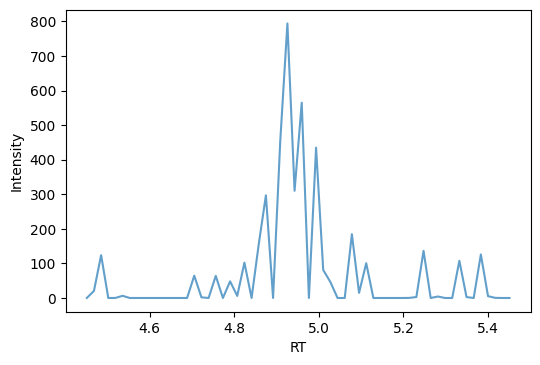

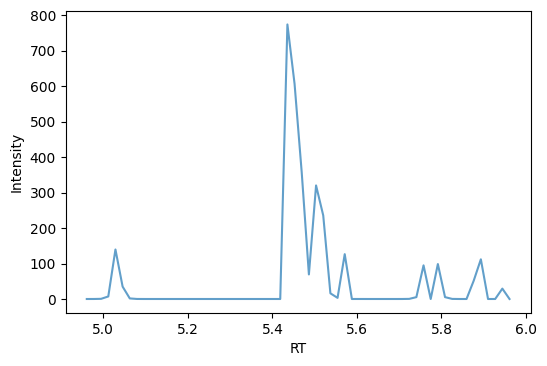

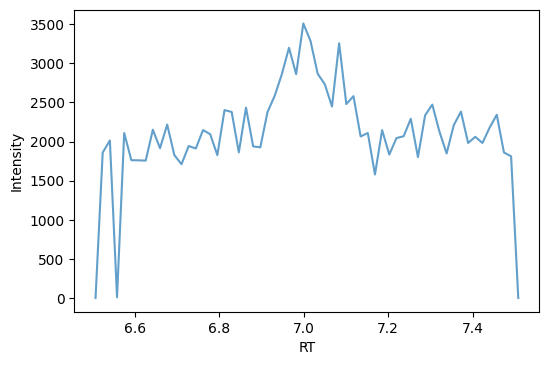

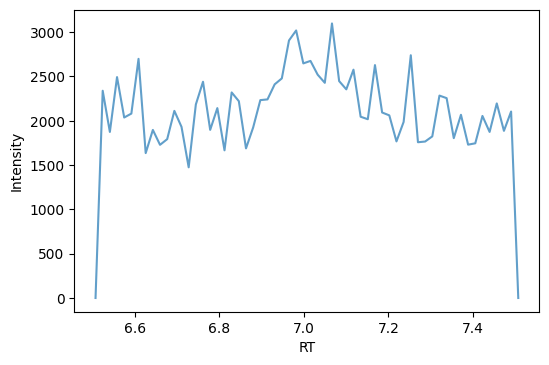

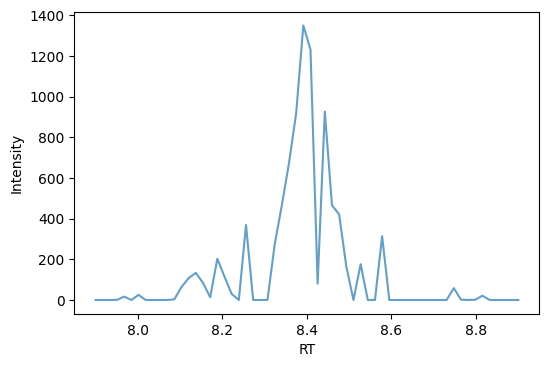

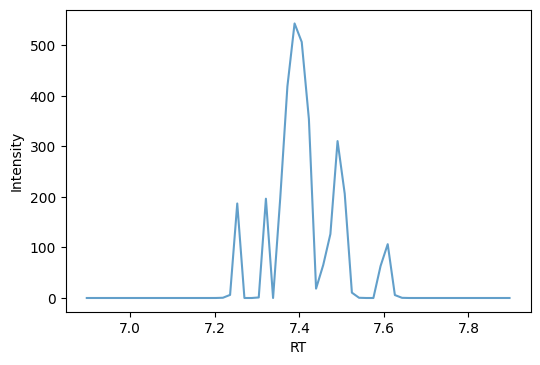

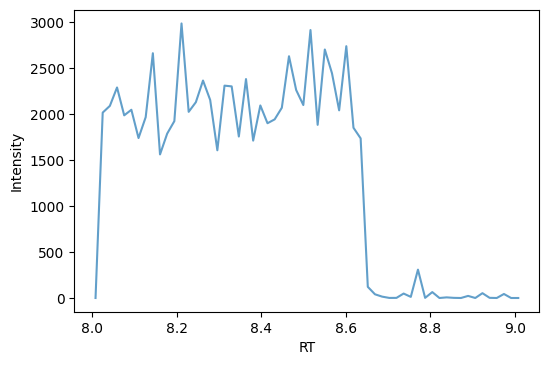

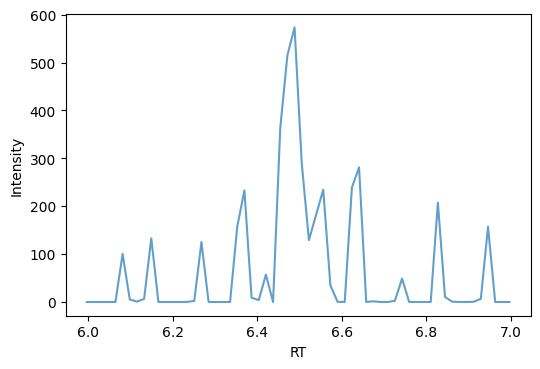

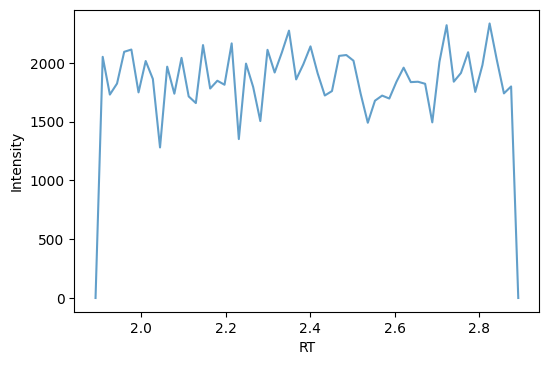

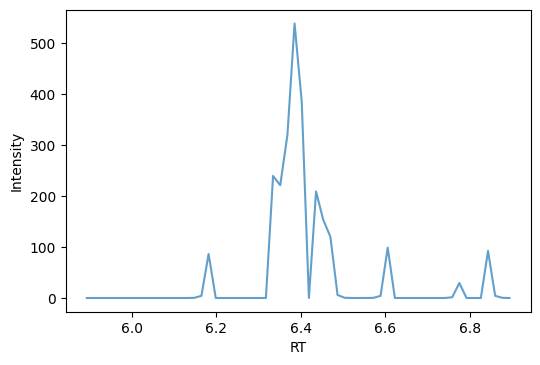

<Figure size 600x400 with 0 Axes>

In [38]:
for ind in fps:
    plot_overlayedEIC(raw_data[:1],peak_curated.at[ind,"mz"],peak_curated.at[ind,"rt"]-.5,peak_curated.at[ind,"rt"] + .5,resolution=resolution,alpha=0.7)
    plt.xlabel("RT")
    plt.ylabel("Intensity")
    plt.figure()

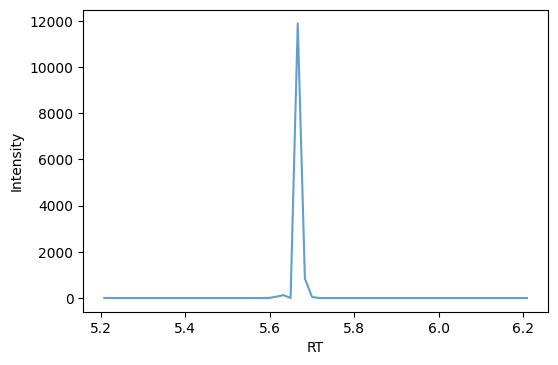

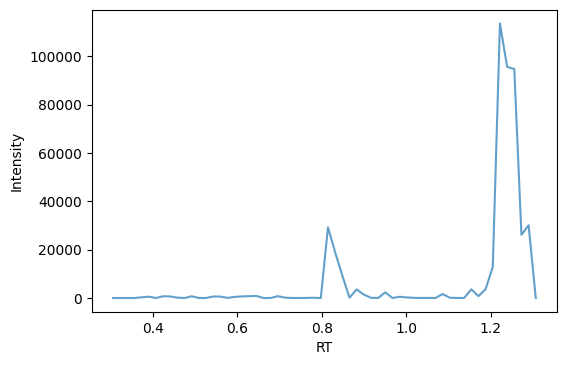

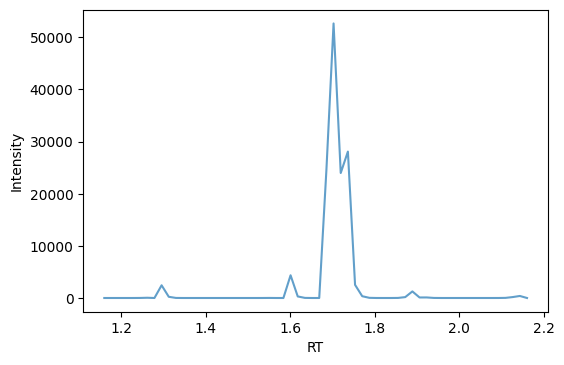

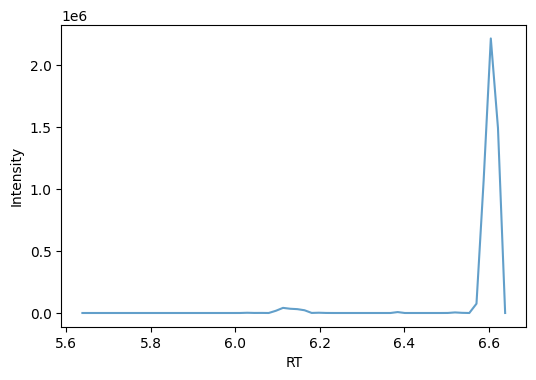

<Figure size 600x400 with 0 Axes>

In [41]:
for ind in fns:
    plot_overlayedEIC(raw_data[:1],peak_curated.at[ind,"mz"],peak_curated.at[ind,"rt"]-.5,peak_curated.at[ind,"rt"] + .5,resolution=resolution,alpha=0.7)
    plt.xlabel("RT")
    plt.ylabel("Intensity")
    plt.figure()

0.8324

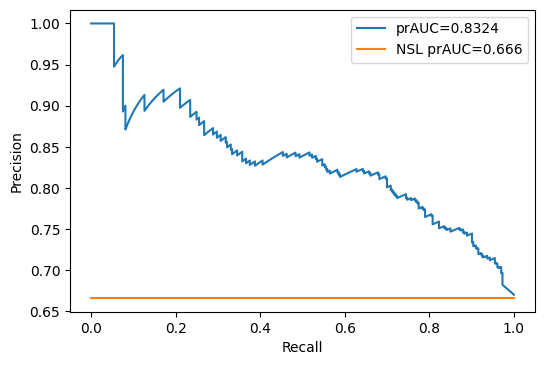

In [42]:
trueInt = []
predInt = []
file = files[0]
for index,row in peakList_labeled.iterrows():
    predInt.append(peak_intensities.at[index,datadir+file])
    trueInt.append(row["classification"])

makePRCPlot(predInt,trueInt)

0.8701

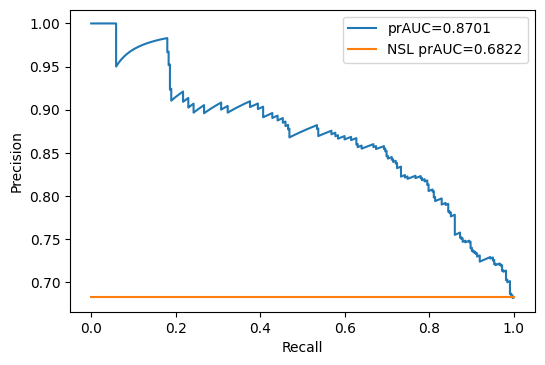

In [43]:
trueCV = []
predCV = []
for index,row in peakList_labeled.iterrows():
    ints = [peak_intensities.at[index,datadir+file] for file in files]
    cv = 1 - np.std(ints) / np.mean(ints)
    if not np.isnan(cv) and not np.isinf(cv) and cv > 0:
        predCV.append(cv)
        trueCV.append(row["classification"])

makePRCPlot(predCV,trueCV)


0.8701

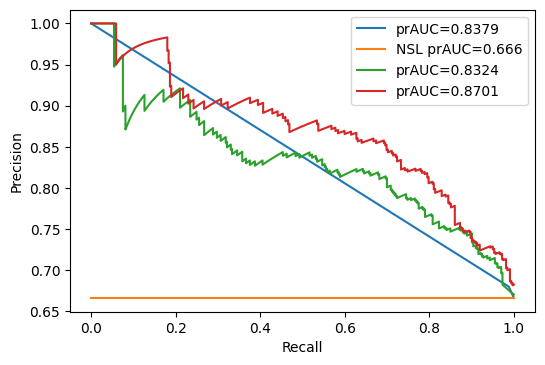

In [44]:
makePRCPlot(pred,true)
makePRCPlot(predInt,trueInt,False)
makePRCPlot(predCV,trueCV,False)

<AxesSubplot:xlabel='classification', ylabel='CV'>

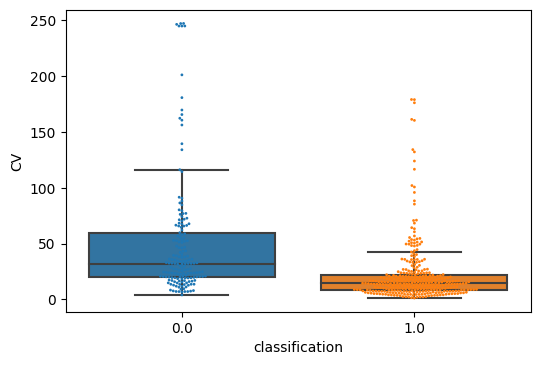

In [45]:
plt_df = {}
for index,row in peakList_labeled.iterrows():
    ints = [peak_intensities.at[index,datadir+file] for file in files]
    cv = 100 * np.std(ints) / np.mean(ints)
    if not np.isnan(cv) and not np.isinf(cv) and cv > 0:
        plt_df[len(plt_df)] = {"classification":row["classification"],"CV":cv}

    
plt_df = pd.DataFrame.from_dict(plt_df,orient="index")


sb.swarmplot(data=plt_df,x="classification",y="CV",s=2)
sb.boxplot(data=plt_df,x="classification",y="CV",fliersize=0)

<AxesSubplot:xlabel='classification', ylabel='intensity'>

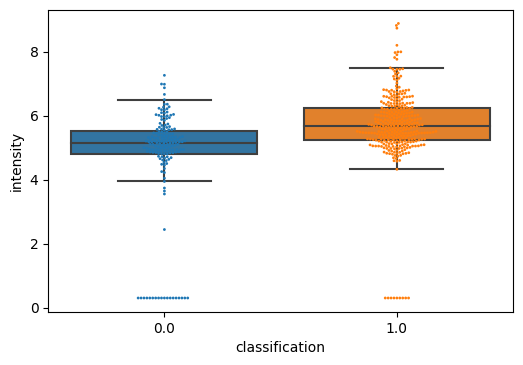

In [46]:
plt_df = {}
file = files[0]
np.log10(np.array([np.max([2, PeakDetective.integratePeak(x)]) for x in X]))
for index,row in peakList_labeled.iterrows():
    plt_df[len(plt_df)] = {"classification":row["classification"],"intensity":np.log10(np.max([2,peak_intensities.at[index,datadir+file]]))}

    
plt_df = pd.DataFrame.from_dict(plt_df,orient="index")


sb.swarmplot(data=plt_df,x="classification",y="intensity",s=2)
sb.boxplot(data=plt_df,x="classification",y="intensity",fliersize=0)

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 48.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 77.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='classification', ylabel='Peak Score'>

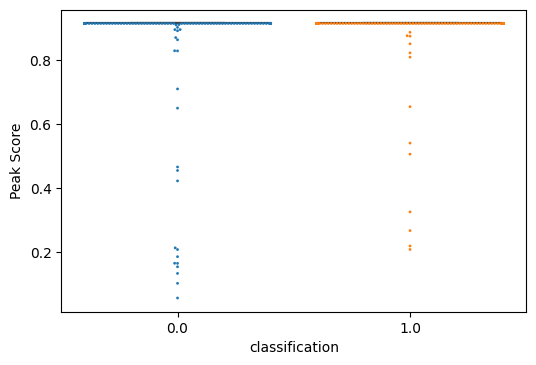

In [47]:
plt_df = {}
file = files[0]
for index,row in peakList_labeled.iterrows():
    plt_df[len(plt_df)] = {"classification":row["classification"],"Peak Score":peak_scores.at[index,datadir+file]}

    
plt_df = pd.DataFrame.from_dict(plt_df,orient="index")


sb.swarmplot(data=plt_df,x="classification",y="Peak Score",s=2)
sb.boxplot(data=plt_df,x="classification",y="Peak Score",fliersize=0)